In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from typing import List


# Task 1: Acquire the data

In [2]:
import pandas as pd
import torch

df_train = pd.read_csv('./sign_mnist_train.csv')
df_test = pd.read_csv("./sign_mnist_test.csv")

X_train, y_train = df_train.iloc[:,1:].values/255.0, df_train.iloc[:,0].values #normalizing takes place here
X_test, y_test = df_test.iloc[:,1:].values/255.0, df_test.iloc[:,0].values

value_counts = {value: np.count_nonzero(y_train == value) for value in range(-1, 31)}

print(value_counts)

from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer() #One hot encoding of the labels
# y_train = lb.fit_transform(y_train)
# y_test = lb.fit_transform(y_test)

print("X_train numpy shape: "+ str(X_train.shape))
print("X_test numpy shape: " +str(X_test.shape))
print("y_train numpy shape: " +str(y_train.shape))
print("y_test numpy shape: " + str(y_test.shape))


X_train_tensor, y_train_tensor = torch.tensor(X_train, dtype=torch.float).reshape(-1, 1, 28, 28), torch.tensor(y_train, dtype=torch.long) #Reshaped to 2D images for the CNN
X_test_tensor, y_test_tensor = torch.tensor(X_test, dtype=torch.float).reshape(-1,1,28,28), torch.tensor(y_test, dtype=torch.long)

print("X_train tensor shape: "+ str(X_train_tensor.shape))
print("X_test tensor shape: " +str(X_test_tensor.shape))
print("y_train tensor shape: " +str(y_train_tensor.shape))
print("y_test tensor shape: " + str(y_test_tensor.shape))


{-1: 0, 0: 1126, 1: 1010, 2: 1144, 3: 1196, 4: 957, 5: 1204, 6: 1090, 7: 1013, 8: 1162, 9: 0, 10: 1114, 11: 1241, 12: 1055, 13: 1151, 14: 1196, 15: 1088, 16: 1279, 17: 1294, 18: 1199, 19: 1186, 20: 1161, 21: 1082, 22: 1225, 23: 1164, 24: 1118, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0}
X_train numpy shape: (27455, 784)
X_test numpy shape: (7172, 784)
y_train numpy shape: (27455,)
y_test numpy shape: (7172,)
X_train tensor shape: torch.Size([27455, 1, 28, 28])
X_test tensor shape: torch.Size([7172, 1, 28, 28])
y_train tensor shape: torch.Size([27455])
y_test tensor shape: torch.Size([7172])


# Task 2: Implement a Multilayer Perceptron

In [18]:
import copy
class MLP:
    def __init__(self, hidden_layers, activation_function='relu', initialization='gaussian',
                 l2_lambda=0, negative_slope=0.1):
        self.hidden_layers = hidden_layers
        self.activation_function = activation_function
        self.weights = []
        self.biases = []
        self.activations = []
        self.alpha = negative_slope

        # Regularization parameters
        self.l2_lambda = l2_lambda

        # Weight and Bias Initialization
        input_size = 28*28
        for units in hidden_layers:
            self.weights.append(self.initialize_weights(input_size, units, initialization))
            self.biases.append(np.zeros((1, units)))
            input_size = units
        self.weights.append(self.initialize_weights(input_size, 25, initialization))
        self.biases.append(np.zeros((1, 25)))

    def initialize_weights(self, size_in, size_out, method):
        if method == 'gaussian':
            return np.random.randn(size_in, size_out)
        else:
            raise ValueError(f"Unknown initialization method: {method}")

    def activation(self, z):
        if self.activation_function == 'relu':
            return np.maximum(0, z)
        elif self.activation_function == 'sigmoid':
            return 1 / (1 + np.exp(-z))
        elif self.activation_function == 'tanh':
            return np.tanh(z)
        elif self.activation_function == 'leakyRelu':
            return np.maximum(0,z) + self.alpha * np.minimum(0,z)
        else:
            raise ValueError(f"Unknown activation function: {self.activation_function}")

    def activation_derivative(self, z):
        if self.activation_function == 'relu':
            return (z > 0).astype(float)
        elif self.activation_function == 'sigmoid':
            sigmoid_val = self.activation(z)
            return sigmoid_val * (1 - sigmoid_val)
        elif self.activation_function == 'tanh':
            tanh_val = self.activation(z)
            return 1.0 - tanh_val**2
        elif self.activation_function == 'leakyRelu':
            return (z > 0) + self.alpha * (z<0)
        else:
            raise ValueError(f"Unknown activation function: {self.activation_function}")

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def compute_loss(self, y_true, y_pred):
        n_samples = y_true.shape[0]
        log_probs = -np.log(y_pred[np.arange(n_samples), y_true.argmax(axis=1)])
        cross_entropy = np.sum(log_probs) / n_samples

        # Regularization
        l2_loss = self.l2_lambda * sum([np.sum(w**2) for w in self.weights])

        return cross_entropy + l2_loss

    def forward_pass(self, X):
        self.activations = [X]
        for i in range(len(self.hidden_layers)):
            z = np.dot(self.activations[-1], self.weights[i]) + self.biases[i]
            self.activations.append(self.activation(z))
        z_out = np.dot(self.activations[-1], self.weights[-1]) + self.biases[-1]
        self.activations.append(self.softmax(z_out))
        return self.activations[-1]

    def backward_pass(self, X, y, learning_rate):
        m = X.shape[0]
        dz = self.activations[-1] - y
        for i in reversed(range(len(self.weights))):
            dw = np.dot(self.activations[i].T, dz) / m
            db = np.sum(dz, axis=0) / m

            # Incorporate L1 and L2 regularization into the weight updates
            dw += self.l2_lambda * self.weights[i] / m

            if i != 0:
                dz = np.dot(dz, self.weights[i].T) * self.activation_derivative(self.activations[i])

            self.weights[i] -= learning_rate * dw
            self.biases[i] -= learning_rate * db


    def fit(self, X, y, learning_rate=0.001, epochs=100, batch_size=64):
        np.random.seed(13) #So that its deterministic
        val_size = int(len(X) * 0.2)  # For an 80/20 split
        indices = np.arange(len(X))
        np.random.shuffle(indices)
        val_indices = indices[:val_size]
        train_indices = indices[val_size:]
        # Use the indices to create training and validation sets
        x_train_fit, y_train_fit = X[train_indices], y[train_indices, :]
        x_val, y_val = X[val_indices], y[val_indices, :]
        
        losses = []

        val_every_ith_epoch = 5
        val_losses = [float('inf')]

        best_params = None
        
        for epoch in tqdm(range(epochs)):
            idx = np.random.permutation(x_train_fit.shape[0])
            X_shuffled = x_train_fit[idx]
            y_shuffled = y_train_fit[idx]
            batch_loss = []
            for i in range(0, x_train_fit.shape[0], batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]
                pred = self.forward_pass(X_batch)
                loss = self.compute_loss(y_batch, pred)
                batch_loss.append(loss)
                self.backward_pass(X_batch, y_batch, learning_rate)
            losses.append(np.mean(batch_loss))

            if epoch % val_every_ith_epoch == 0:
                pred_val = self.forward_pass(x_val)
                loss_val = self.compute_loss(y_val, pred_val)
                if loss_val< np.min(val_losses):
                    best_params = (copy.deepcopy(self.weights), copy.deepcopy(self.biases))
                val_losses.append(loss_val)
    
        return best_params, losses, val_losses


    def predict(self, X):
        predictions = self.forward_pass(X)
        return np.argmax(predictions, axis=1)


In [4]:
def evaluate_accuracy(y_true, predicted_probabilities):
    predicted_classes = np.argmax(predicted_probabilities, axis=1)
    correct_predictions = predicted_classes == y_true
    accuracy = np.mean(correct_predictions) 
    return accuracy

In [5]:
def get_accuracy_stats(mlp :MLP, best_params_no_val, best_params_val, X_test, y_test, X_train, y_train):
    mlp.weights, mlp.biases = best_params_no_val
    accuracy_no_val_train = evaluate_accuracy(y_train, mlp.forward_pass(X_train))*100
    accuracy_no_val_test = evaluate_accuracy(y_test, mlp.forward_pass(X_test))*100

    mlp.weights, mlp.biases = best_params_val
    accuracy_val_train = evaluate_accuracy(y_train, mlp.forward_pass(X_train))*100
    accuracy_val_test = evaluate_accuracy(y_test, mlp.forward_pass(X_test))*100

    print(f"Train accuracy no validation = {accuracy_no_val_train:.2f}%")
    print(f"Test accuracy no validation = {accuracy_no_val_test:.2f}%")
    print(f"Train accuracy with validation = {accuracy_val_train:.2f}%")
    print(f"Test accuracy with validation = {accuracy_val_test:.2f}%")
    return accuracy_no_val_train,accuracy_no_val_test,accuracy_val_train, accuracy_val_test

In [6]:
from scipy.interpolate import interp1d
def plot_losses(losses, val_losses):
    if len(val_losses) > 0 and (np.isinf(val_losses[0]) or np.isnan(val_losses[0])):
        val_losses = val_losses[1:]  # We eliminate the first value since it's infinite or NaN
    
    total_epochs = len(losses)
    
    # Original epochs for validation losses
    original_val_epochs = np.linspace(1, total_epochs, len(val_losses), endpoint=True)
    
    # Interpolation for validation losses to match the total_epochs
    interp = interp1d(original_val_epochs, val_losses, kind='linear')
    interpolated_val_epochs = np.linspace(1, total_epochs, total_epochs, endpoint=True)
    interpolated_val_losses = interp(interpolated_val_epochs)
    
    plt.plot(range(1, total_epochs + 1), losses, label='Training Loss', linestyle='-', color='blue')
    plt.plot(interpolated_val_epochs, interpolated_val_losses, label='Validation Loss', linestyle='--', color='orange')
    
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.yscale("log")  # Using logarithmic scale for better visibility if losses vary widely
    plt.legend()
    plt.title("Training vs Validation Loss")
    plt.show()

### Base Case (if needed)


<h2> #Task 3: Run the experiments </h2>

In [7]:
y_train_ohe = np.eye(25)[y_train]

<h3> 3.1 </h3>

<h5> No hidden layer </h5>

100%|██████████| 400/400 [04:03<00:00,  1.64it/s]


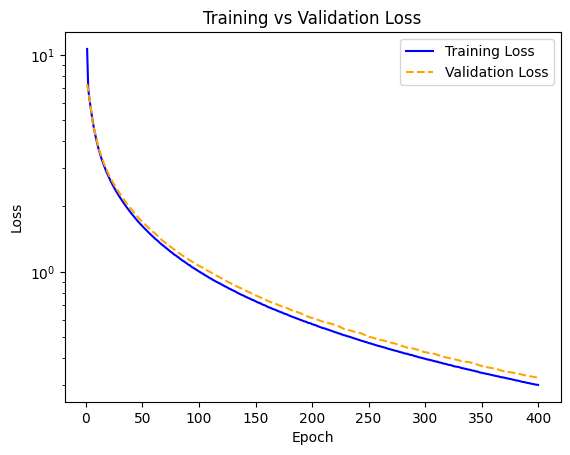

Train accuracy no validation = 93.89%
Test accuracy no validation = 61.74%
Train accuracy with validation = 93.85%
Test accuracy with validation = 61.17%


In [35]:
mlp = MLP(hidden_layers=[], activation_function='relu')
best_val_params, train_losses, val_losses = mlp.fit(X_train, y_train_ohe, learning_rate=0.01, epochs=400)
best_no_val_params = (copy.deepcopy(mlp.weights), copy.deepcopy(mlp.biases))
plot_losses(train_losses, val_losses)
no_hidden_layer_stats = get_accuracy_stats(mlp, best_no_val_params, best_val_params, X_test, y_test, X_train, y_train)

<h5> 1 hidden layer </h5>

In [ ]:
#Hyperparameter optimization --> Need to redo because we had momentum

"""We might be able to use the scikit-learn MLP implementation to find out which model parameters are ideal.
In this way, we perform a grid search of all possible combinations, and then we basically report the one that's the best. Then, using the best
model structure from the scikit-learn MLP implementation, we can train our MLP implementation and see if the accuracy is similar.

We can also try and have our MLP implementation implement all the method required when passed to GridSearchCV so that GridSearchCV can be used
directly with out MLP implementation.
"""


from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'hidden_layer_sizes': [(32,), (64,), (128,), (256,)],  # Single layer with varying sizes
    'learning_rate_init': [0.001, 0.01, 0.1, 1]
}

#No regularization alpha = 0.0
scimlp = MLPClassifier(activation='relu', solver='sgd', alpha=0.0, batch_size=128, max_iter=400, momentum=0, validation_fraction=0.2)
grid_search = GridSearchCV(scimlp, param_grid, cv=5, verbose=2)  #cv is K-fold cross validation, verbose is amount of detail printed to console
grid_search.fit(X_train, y_train)




From here on end, we try to confirm validity of GridSearch w/ our implementation

100%|██████████| 400/400 [04:50<00:00,  1.38it/s]


1 HIDDEN LAYER WITH 32 units and a 1.00 learning rate


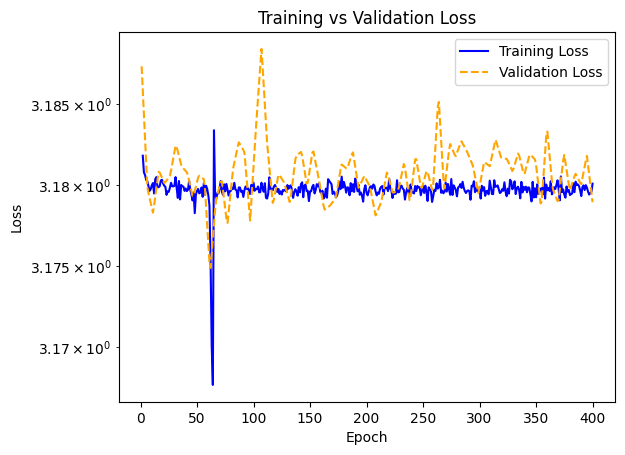

Train accuracy no validation = 4.37%
Test accuracy no validation = 3.43%
Train accuracy with validation = 5.04%
Test accuracy with validation = 2.01%







100%|██████████| 400/400 [04:53<00:00,  1.36it/s]


1 HIDDEN LAYER WITH 32 units and a 0.10 learning rate


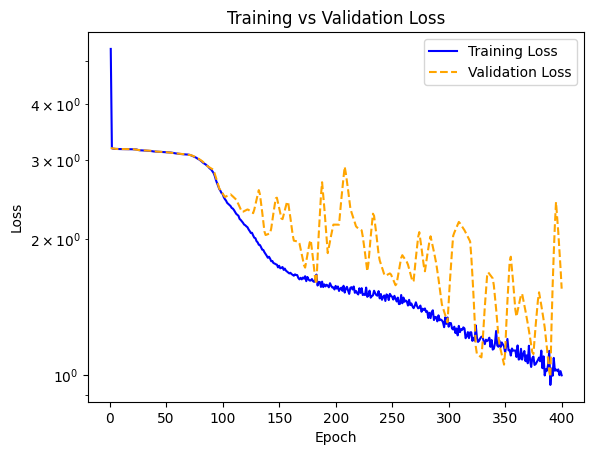

Train accuracy no validation = 43.94%
Test accuracy no validation = 28.82%
Train accuracy with validation = 65.29%
Test accuracy with validation = 41.94%







100%|██████████| 400/400 [05:06<00:00,  1.31it/s]


1 HIDDEN LAYER WITH 32 units and a 0.01 learning rate


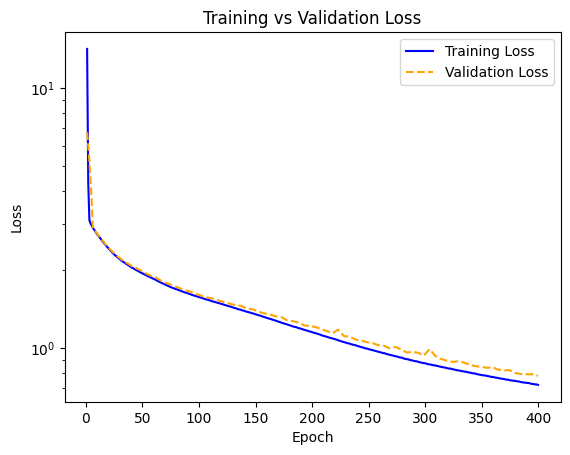

Train accuracy no validation = 76.21%
Test accuracy no validation = 48.15%
Train accuracy with validation = 75.97%
Test accuracy with validation = 48.45%







100%|██████████| 400/400 [04:58<00:00,  1.34it/s]


1 HIDDEN LAYER WITH 32 units and a 0.00 learning rate


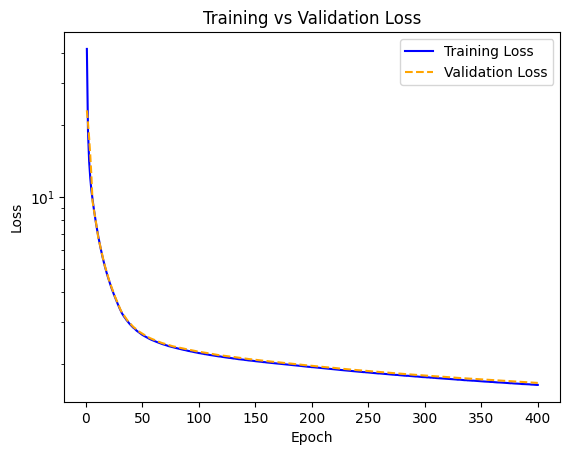

Train accuracy no validation = 47.14%
Test accuracy no validation = 42.93%
Train accuracy with validation = 46.92%
Test accuracy with validation = 42.97%







100%|██████████| 400/400 [06:46<00:00,  1.02s/it]


1 HIDDEN LAYER WITH 64 units and a 1.00 learning rate


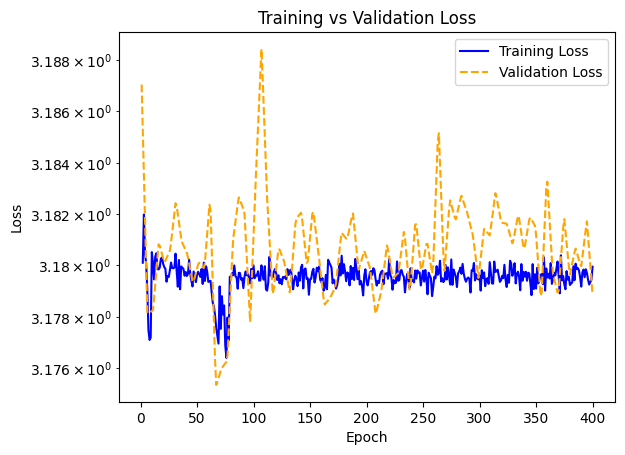

Train accuracy no validation = 4.37%
Test accuracy no validation = 3.43%
Train accuracy with validation = 4.44%
Test accuracy with validation = 3.44%







100%|██████████| 400/400 [05:31<00:00,  1.21it/s]


1 HIDDEN LAYER WITH 64 units and a 0.10 learning rate


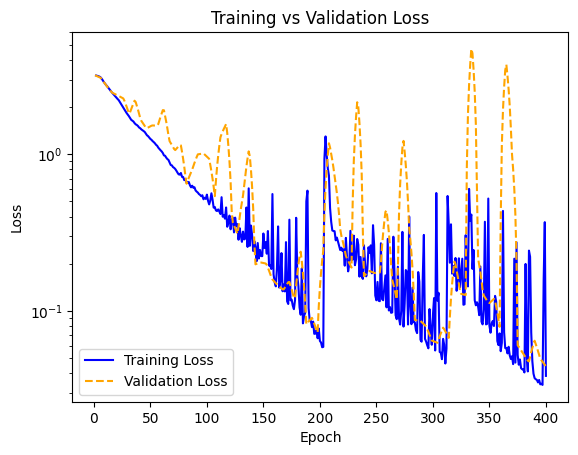

Train accuracy no validation = 99.30%
Test accuracy no validation = 54.32%
Train accuracy with validation = 99.47%
Test accuracy with validation = 56.00%







100%|██████████| 400/400 [04:50<00:00,  1.38it/s]


1 HIDDEN LAYER WITH 64 units and a 0.01 learning rate


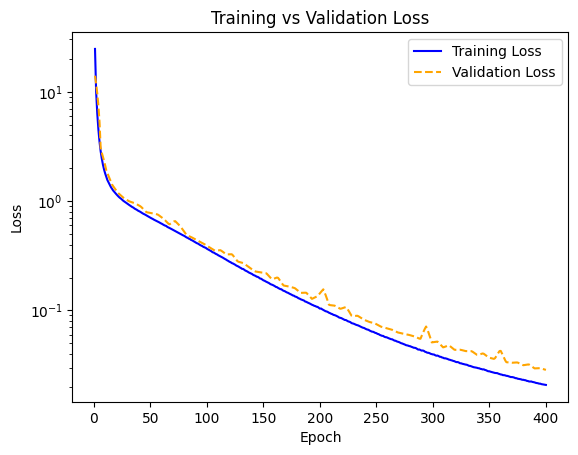

Train accuracy no validation = 99.88%
Test accuracy no validation = 63.92%
Train accuracy with validation = 99.88%
Test accuracy with validation = 63.72%







100%|██████████| 400/400 [05:00<00:00,  1.33it/s]


1 HIDDEN LAYER WITH 64 units and a 0.00 learning rate


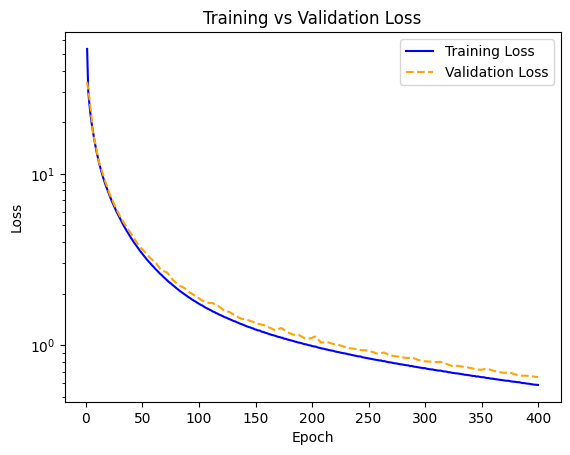

Train accuracy no validation = 81.74%
Test accuracy no validation = 54.11%
Train accuracy with validation = 81.64%
Test accuracy with validation = 53.99%







100%|██████████| 400/400 [13:33<00:00,  2.03s/it]


1 HIDDEN LAYER WITH 128 units and a 1.00 learning rate


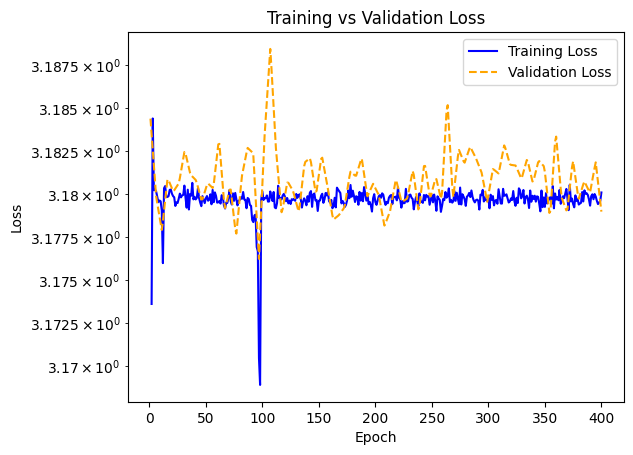

Train accuracy no validation = 4.37%
Test accuracy no validation = 3.43%
Train accuracy with validation = 4.76%
Test accuracy with validation = 2.29%







100%|██████████| 400/400 [16:30<00:00,  2.48s/it]


1 HIDDEN LAYER WITH 128 units and a 0.10 learning rate


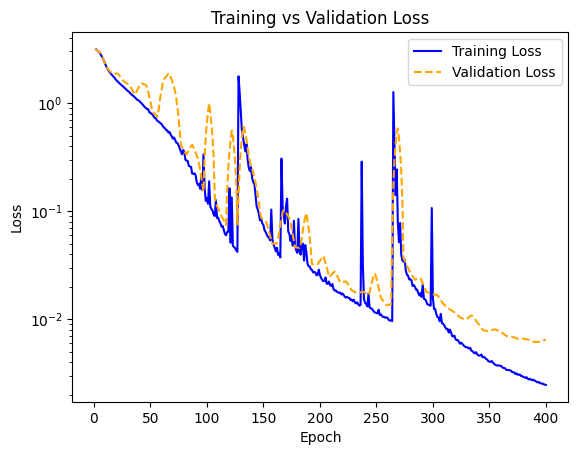

Train accuracy no validation = 99.97%
Test accuracy no validation = 59.20%
Train accuracy with validation = 99.98%
Test accuracy with validation = 59.41%







100%|██████████| 400/400 [16:47<00:00,  2.52s/it]


1 HIDDEN LAYER WITH 128 units and a 0.01 learning rate


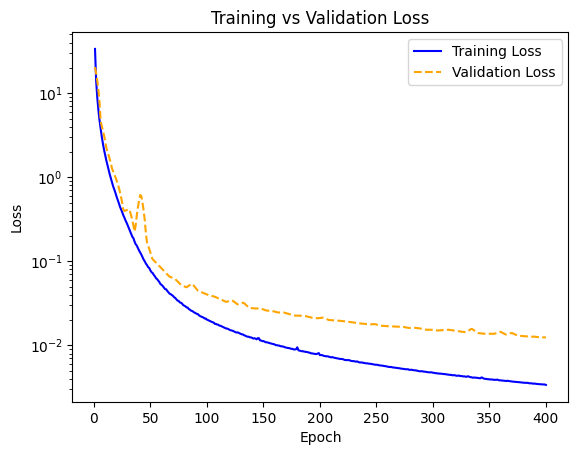

Train accuracy no validation = 99.94%
Test accuracy no validation = 58.53%
Train accuracy with validation = 99.95%
Test accuracy with validation = 58.21%







100%|██████████| 400/400 [16:21<00:00,  2.45s/it]


1 HIDDEN LAYER WITH 128 units and a 0.00 learning rate


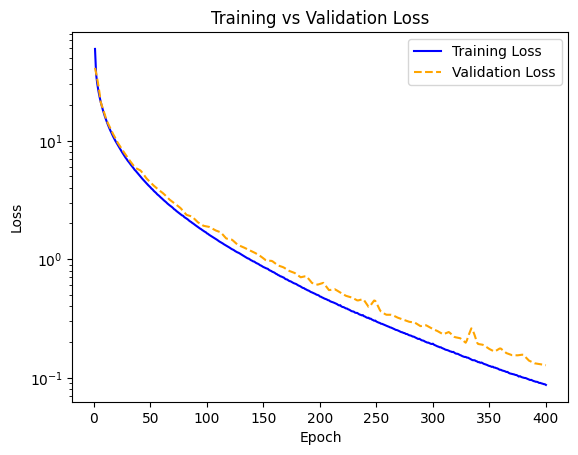

Train accuracy no validation = 97.54%
Test accuracy no validation = 51.90%
Train accuracy with validation = 97.42%
Test accuracy with validation = 51.88%







100%|██████████| 400/400 [45:05<00:00,  6.76s/it]


1 HIDDEN LAYER WITH 256 units and a 1.00 learning rate


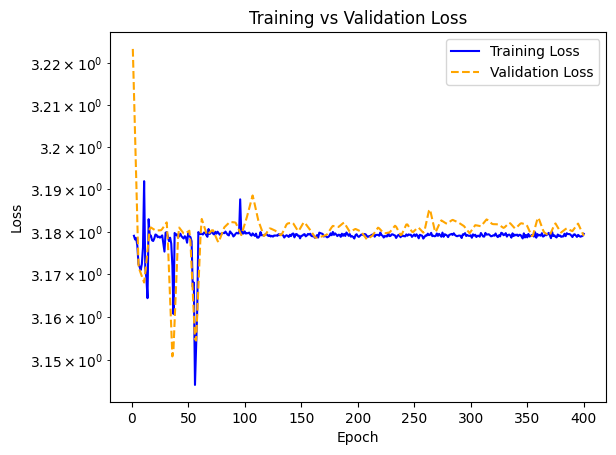

Train accuracy no validation = 4.39%
Test accuracy no validation = 3.43%
Train accuracy with validation = 5.91%
Test accuracy with validation = 5.12%







100%|██████████| 400/400 [45:40<00:00,  6.85s/it]


1 HIDDEN LAYER WITH 256 units and a 0.10 learning rate


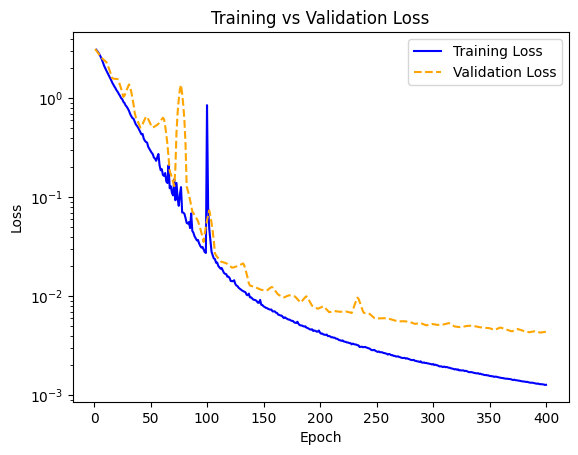

Train accuracy no validation = 99.98%
Test accuracy no validation = 61.06%
Train accuracy with validation = 99.98%
Test accuracy with validation = 61.28%







100%|██████████| 400/400 [45:22<00:00,  6.81s/it]


1 HIDDEN LAYER WITH 256 units and a 0.01 learning rate


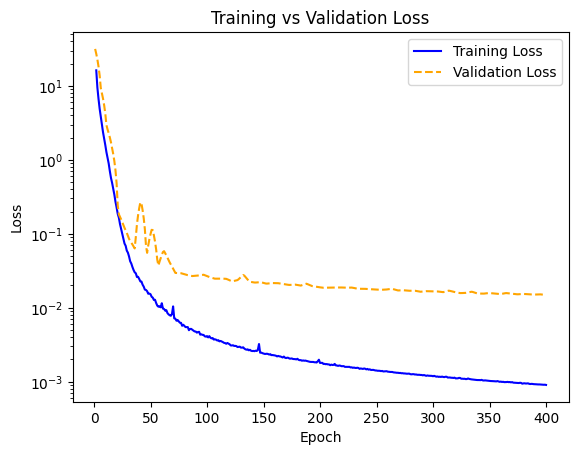

Train accuracy no validation = 99.90%
Test accuracy no validation = 60.72%
Train accuracy with validation = 99.91%
Test accuracy with validation = 60.72%







100%|██████████| 400/400 [46:01<00:00,  6.90s/it]


1 HIDDEN LAYER WITH 256 units and a 0.00 learning rate


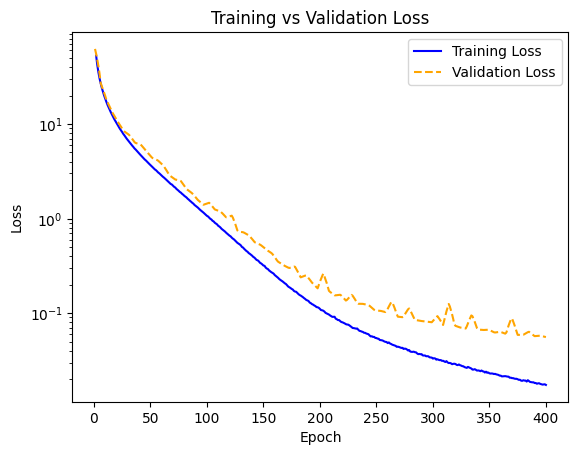

Train accuracy no validation = 99.52%
Test accuracy no validation = 57.12%
Train accuracy with validation = 99.48%
Test accuracy with validation = 57.01%







In [36]:
HIDDEN_UNITS = [32,64,128,256]
learning_rates = [1e0, 1e-1, 1e-2, 1e-3]
for i in HIDDEN_UNITS:
    for j in learning_rates:
        mlp = MLP(hidden_layers=[i], activation_function='relu')
        best_val_params, train_losses, val_losses = mlp.fit(X_train, y_train_ohe, learning_rate=j, epochs=400)
        best_no_val_params = (copy.deepcopy(mlp.weights), copy.deepcopy(mlp.biases))
        print(f"1 HIDDEN LAYER WITH {i} units and a {j:.2f} learning rate")
        plot_losses(train_losses, val_losses)
        no_hidden_layer_stats = get_accuracy_stats(mlp, best_no_val_params, best_val_params, X_test, y_test, X_train, y_train)
        print("\n\n\n\n")

Best 1 hidden layer --> 256 at 0.1 lr

<h5> 2 hidden layer -> we reject the 32 1st hidden layer as the test accuracy was below 0.59 for optimal learning rate </h5>

In [ ]:
#Hyperparameter optimization


from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'hidden_layer_sizes': [(128,32), (128,64), (128,128), (128,256)],  # Single layer with varying sizes
    'learning_rate_init': [0.001, 0.01, 0.1, 1]
}

#No regularization alpha = 0.0
scimlp = MLPClassifier(activation='relu', solver='sgd', alpha=0.0, batch_size=128, max_iter=400, momentum=0, validation_fraction=0.2)
grid_search = GridSearchCV(scimlp, param_grid, cv=5, verbose=2)  #cv is K-fold cross validation, verbose is amount of detail printed to console
grid_search.fit(X_train, y_train)

100%|██████████| 100/100 [00:58<00:00,  1.71it/s]


2 HIDDEN LAYER WITH (64, 32) units and a 1.0 learning rate


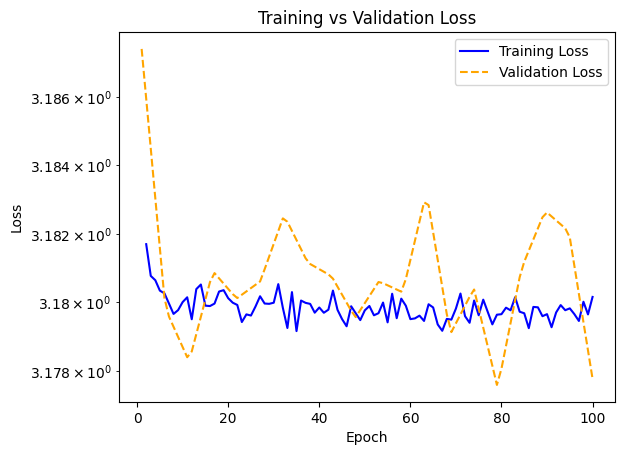

Train accuracy no validation = 4.71%
Test accuracy no validation = 2.01%
Train accuracy with validation = 4.71%
Test accuracy with validation = 2.01%







100%|██████████| 100/100 [01:03<00:00,  1.57it/s]


2 HIDDEN LAYER WITH (64, 64) units and a 1.0 learning rate


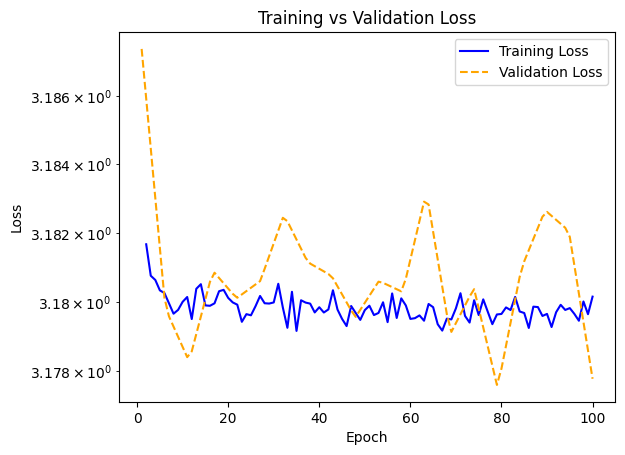

Train accuracy no validation = 4.71%
Test accuracy no validation = 2.01%
Train accuracy with validation = 4.71%
Test accuracy with validation = 2.01%







100%|██████████| 100/100 [01:11<00:00,  1.39it/s]


2 HIDDEN LAYER WITH (64, 128) units and a 1.0 learning rate


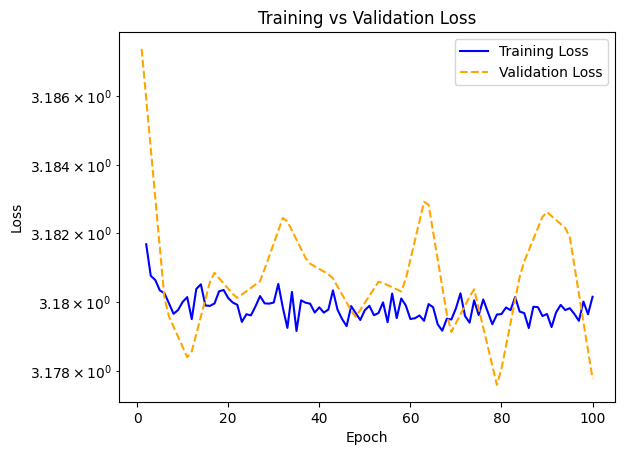

Train accuracy no validation = 4.71%
Test accuracy no validation = 2.01%
Train accuracy with validation = 4.71%
Test accuracy with validation = 2.01%







100%|██████████| 100/100 [01:43<00:00,  1.03s/it]


2 HIDDEN LAYER WITH (64, 256) units and a 1.0 learning rate


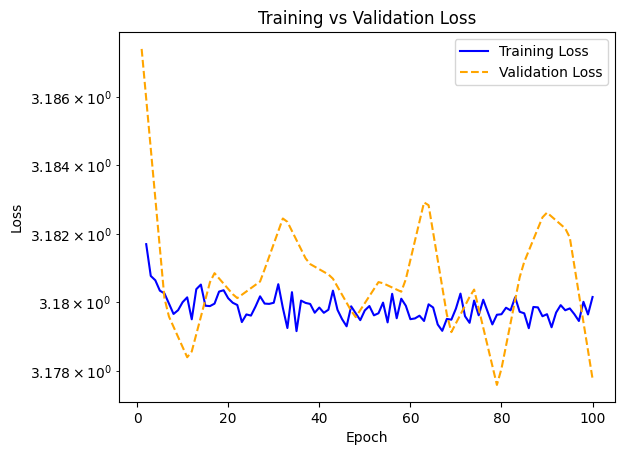

Train accuracy no validation = 4.71%
Test accuracy no validation = 2.01%
Train accuracy with validation = 4.71%
Test accuracy with validation = 2.01%







100%|██████████| 100/100 [01:04<00:00,  1.55it/s]


2 HIDDEN LAYER WITH (64, 32) units and a 0.1 learning rate


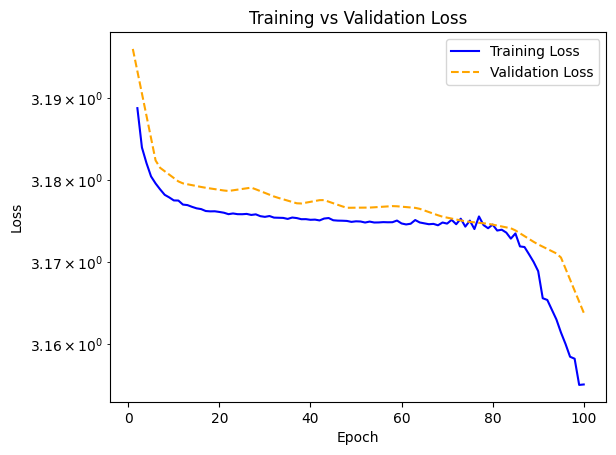

Train accuracy no validation = 5.34%
Test accuracy no validation = 2.48%
Train accuracy with validation = 5.26%
Test accuracy with validation = 2.31%







100%|██████████| 100/100 [01:07<00:00,  1.49it/s]


2 HIDDEN LAYER WITH (64, 64) units and a 0.1 learning rate


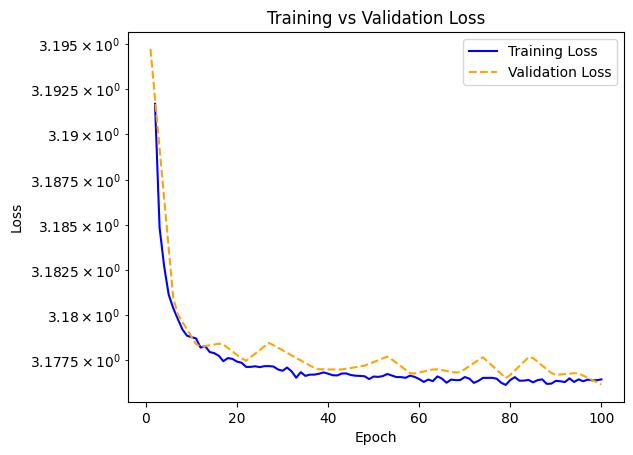

Train accuracy no validation = 4.72%
Test accuracy no validation = 2.01%
Train accuracy with validation = 4.72%
Test accuracy with validation = 2.01%







100%|██████████| 100/100 [01:16<00:00,  1.30it/s]


2 HIDDEN LAYER WITH (64, 128) units and a 0.1 learning rate


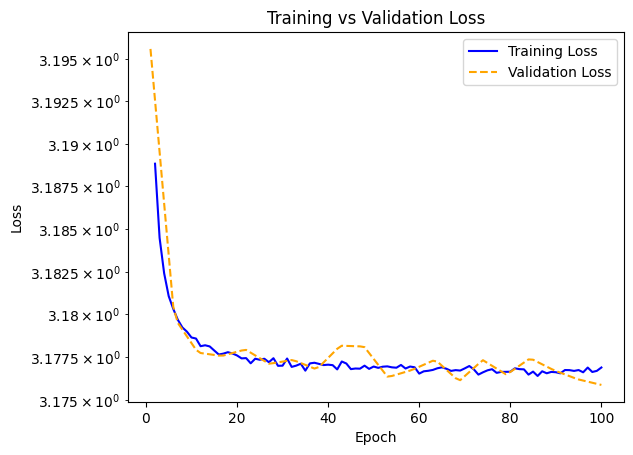

Train accuracy no validation = 4.71%
Test accuracy no validation = 2.01%
Train accuracy with validation = 4.71%
Test accuracy with validation = 2.01%







100%|██████████| 100/100 [01:43<00:00,  1.04s/it]


2 HIDDEN LAYER WITH (64, 256) units and a 0.1 learning rate


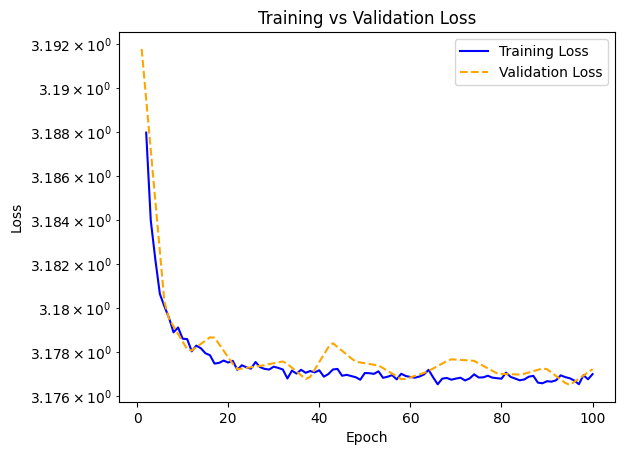

Train accuracy no validation = 4.71%
Test accuracy no validation = 2.01%
Train accuracy with validation = 4.71%
Test accuracy with validation = 2.01%







100%|██████████| 100/100 [01:04<00:00,  1.56it/s]


2 HIDDEN LAYER WITH (64, 32) units and a 0.01 learning rate


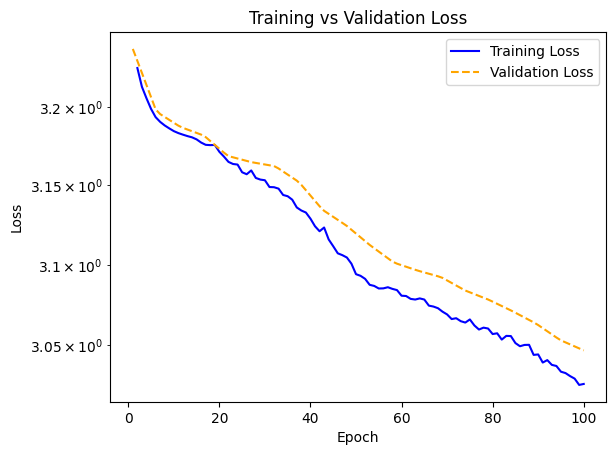

Train accuracy no validation = 8.34%
Test accuracy no validation = 4.66%
Train accuracy with validation = 8.47%
Test accuracy with validation = 4.60%







100%|██████████| 100/100 [01:05<00:00,  1.54it/s]


2 HIDDEN LAYER WITH (64, 64) units and a 0.01 learning rate


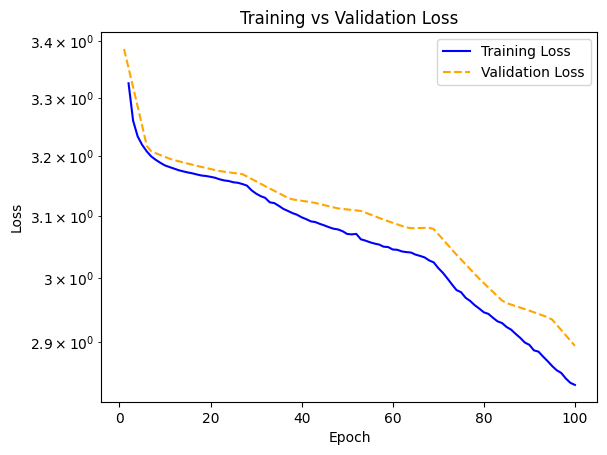

Train accuracy no validation = 13.37%
Test accuracy no validation = 8.53%
Train accuracy with validation = 13.01%
Test accuracy with validation = 9.02%







100%|██████████| 100/100 [01:17<00:00,  1.29it/s]


2 HIDDEN LAYER WITH (64, 128) units and a 0.01 learning rate


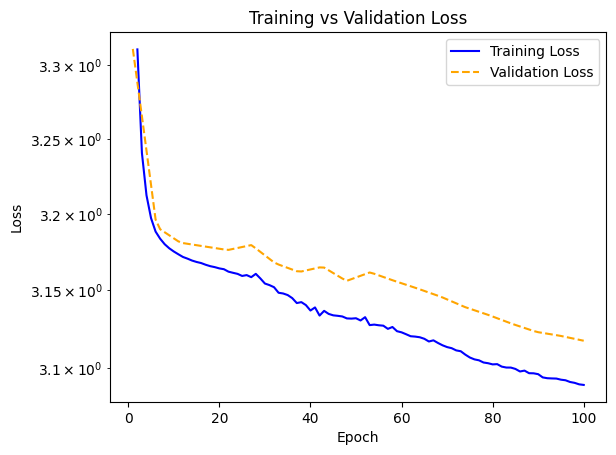

Train accuracy no validation = 7.46%
Test accuracy no validation = 3.42%
Train accuracy with validation = 7.37%
Test accuracy with validation = 3.26%







100%|██████████| 100/100 [01:52<00:00,  1.13s/it]


2 HIDDEN LAYER WITH (64, 256) units and a 0.01 learning rate


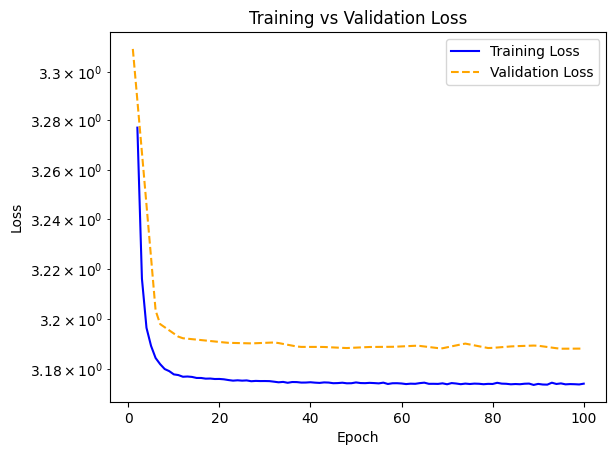

Train accuracy no validation = 4.79%
Test accuracy no validation = 2.01%
Train accuracy with validation = 4.79%
Test accuracy with validation = 2.01%







100%|██████████| 100/100 [01:04<00:00,  1.56it/s]


2 HIDDEN LAYER WITH (64, 32) units and a 0.001 learning rate


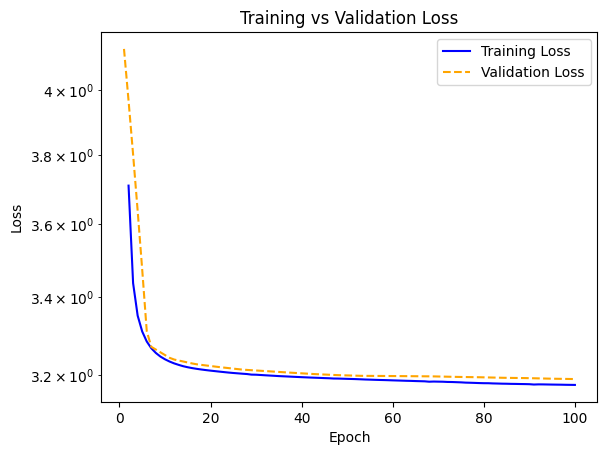

Train accuracy no validation = 5.29%
Test accuracy no validation = 2.52%
Train accuracy with validation = 5.28%
Test accuracy with validation = 2.52%







100%|██████████| 100/100 [01:05<00:00,  1.53it/s]


2 HIDDEN LAYER WITH (64, 64) units and a 0.001 learning rate


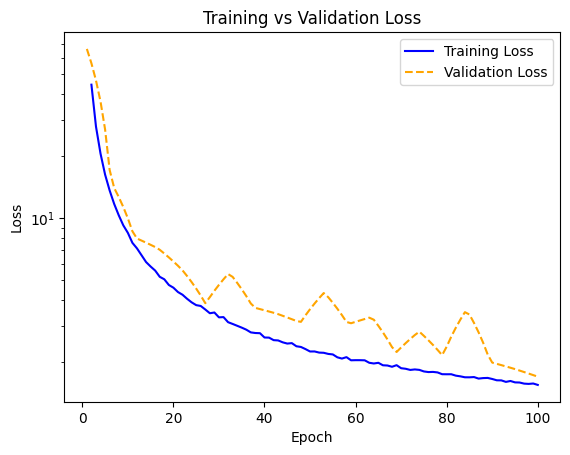

Train accuracy no validation = 50.69%
Test accuracy no validation = 38.41%
Train accuracy with validation = 53.23%
Test accuracy with validation = 37.72%







100%|██████████| 100/100 [01:15<00:00,  1.33it/s]


2 HIDDEN LAYER WITH (64, 128) units and a 0.001 learning rate


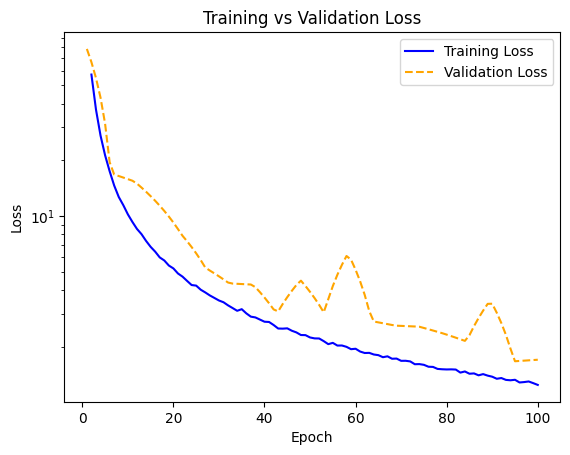

Train accuracy no validation = 61.46%
Test accuracy no validation = 41.59%
Train accuracy with validation = 61.69%
Test accuracy with validation = 39.08%







100%|██████████| 100/100 [01:46<00:00,  1.06s/it]


2 HIDDEN LAYER WITH (64, 256) units and a 0.001 learning rate


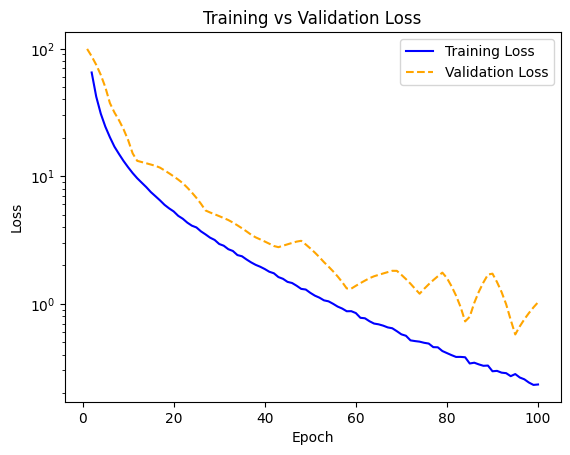

Train accuracy no validation = 94.93%
Test accuracy no validation = 46.65%
Train accuracy with validation = 94.59%
Test accuracy with validation = 47.18%







100%|██████████| 100/100 [01:26<00:00,  1.16it/s]


2 HIDDEN LAYER WITH (128, 32) units and a 1.0 learning rate


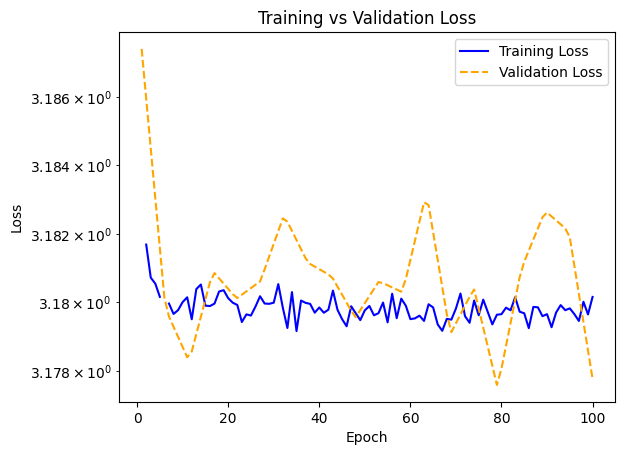

Train accuracy no validation = 4.71%
Test accuracy no validation = 2.01%
Train accuracy with validation = 4.71%
Test accuracy with validation = 2.01%







100%|██████████| 100/100 [02:16<00:00,  1.36s/it]


2 HIDDEN LAYER WITH (128, 64) units and a 1.0 learning rate


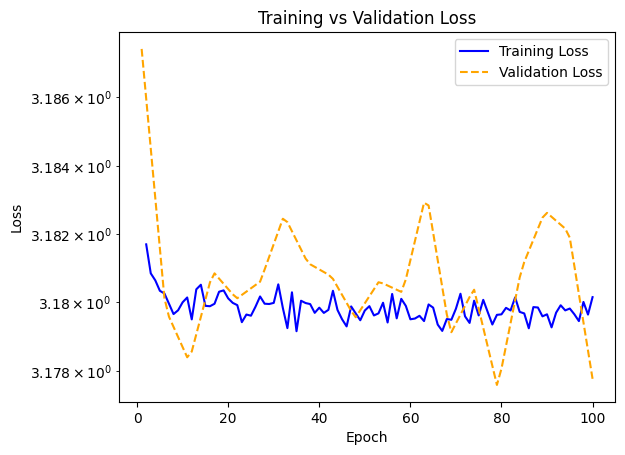

Train accuracy no validation = 4.71%
Test accuracy no validation = 2.01%
Train accuracy with validation = 4.71%
Test accuracy with validation = 2.01%







100%|██████████| 100/100 [02:08<00:00,  1.29s/it]


2 HIDDEN LAYER WITH (128, 128) units and a 1.0 learning rate


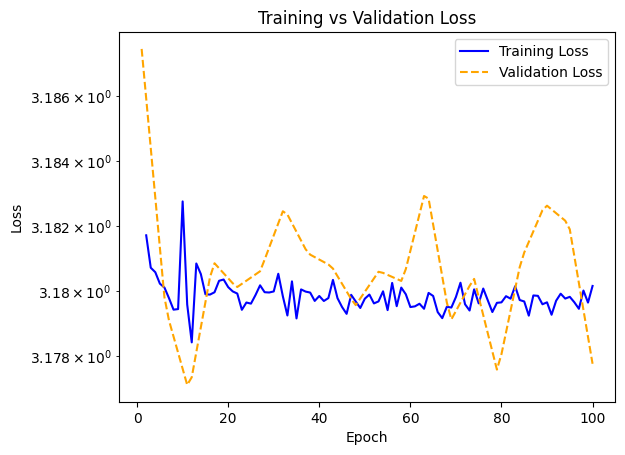

Train accuracy no validation = 4.71%
Test accuracy no validation = 2.01%
Train accuracy with validation = 4.56%
Test accuracy with validation = 3.04%







100%|██████████| 100/100 [02:56<00:00,  1.76s/it]


2 HIDDEN LAYER WITH (128, 256) units and a 1.0 learning rate


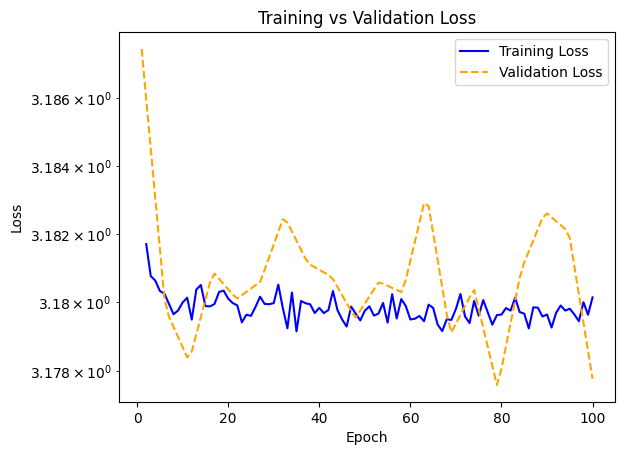

Train accuracy no validation = 4.71%
Test accuracy no validation = 2.01%
Train accuracy with validation = 4.71%
Test accuracy with validation = 2.01%







100%|██████████| 100/100 [02:20<00:00,  1.40s/it]


2 HIDDEN LAYER WITH (128, 32) units and a 0.1 learning rate


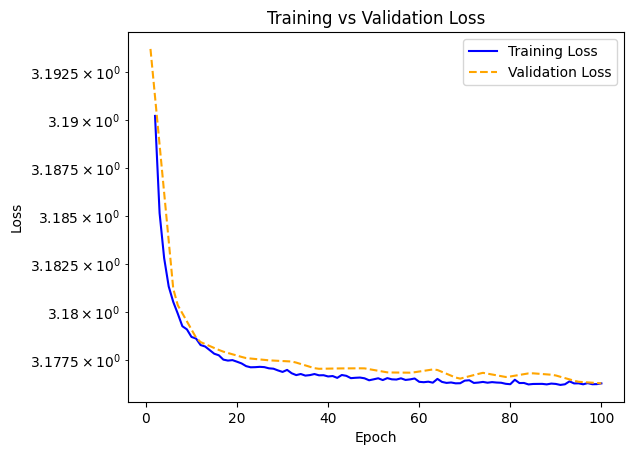

Train accuracy no validation = 4.71%
Test accuracy no validation = 2.01%
Train accuracy with validation = 4.71%
Test accuracy with validation = 2.01%







100%|██████████| 100/100 [02:30<00:00,  1.51s/it]


2 HIDDEN LAYER WITH (128, 64) units and a 0.1 learning rate


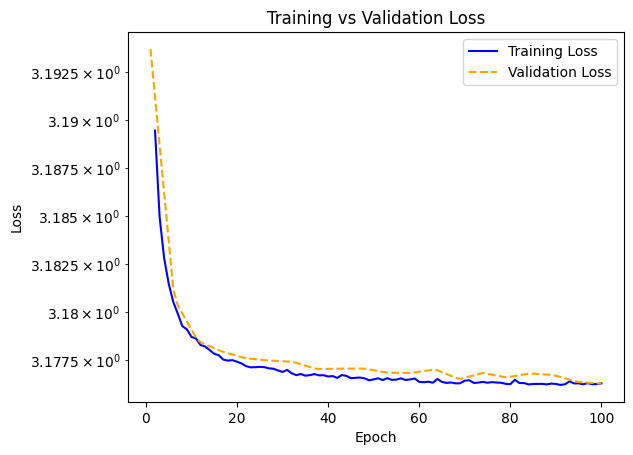

Train accuracy no validation = 4.71%
Test accuracy no validation = 2.01%
Train accuracy with validation = 4.71%
Test accuracy with validation = 2.01%







100%|██████████| 100/100 [02:17<00:00,  1.37s/it]


2 HIDDEN LAYER WITH (128, 128) units and a 0.1 learning rate


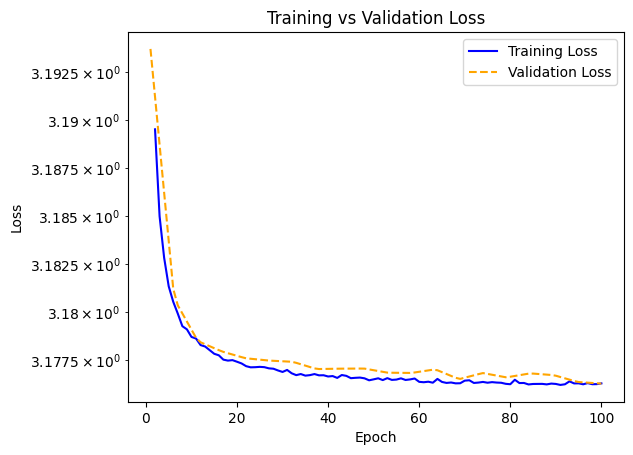

Train accuracy no validation = 4.71%
Test accuracy no validation = 2.01%
Train accuracy with validation = 4.71%
Test accuracy with validation = 2.01%







100%|██████████| 100/100 [02:43<00:00,  1.63s/it]


2 HIDDEN LAYER WITH (128, 256) units and a 0.1 learning rate


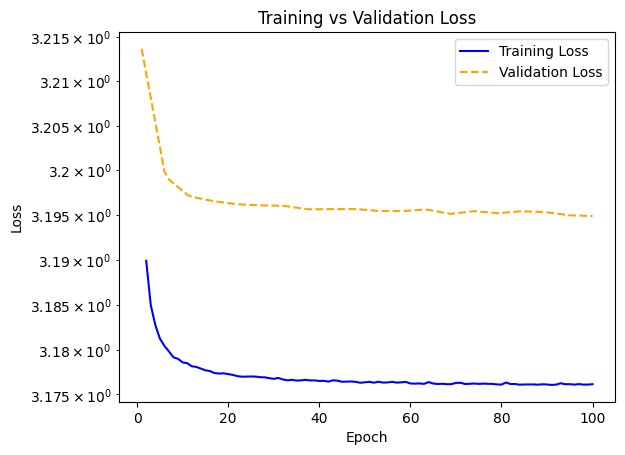

Train accuracy no validation = 4.72%
Test accuracy no validation = 2.01%
Train accuracy with validation = 4.72%
Test accuracy with validation = 2.01%







100%|██████████| 100/100 [18:27<00:00, 11.07s/it]  

2 HIDDEN LAYER WITH (128, 32) units and a 0.01 learning rate


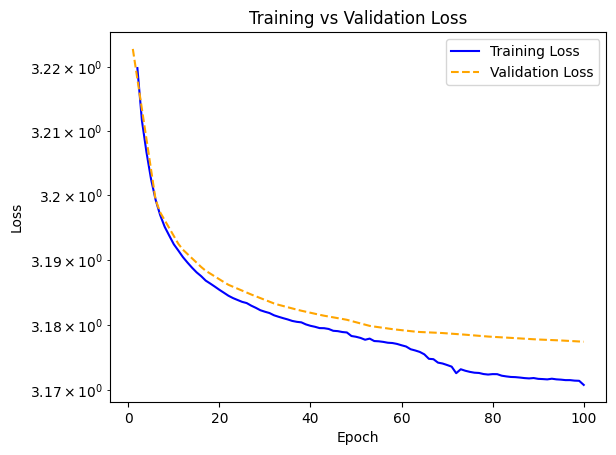

Train accuracy no validation = 4.89%
Test accuracy no validation = 2.33%
Train accuracy with validation = 4.89%
Test accuracy with validation = 2.33%







100%|██████████| 100/100 [01:36<00:00,  1.04it/s]

2 HIDDEN LAYER WITH (128, 64) units and a 0.01 learning rate


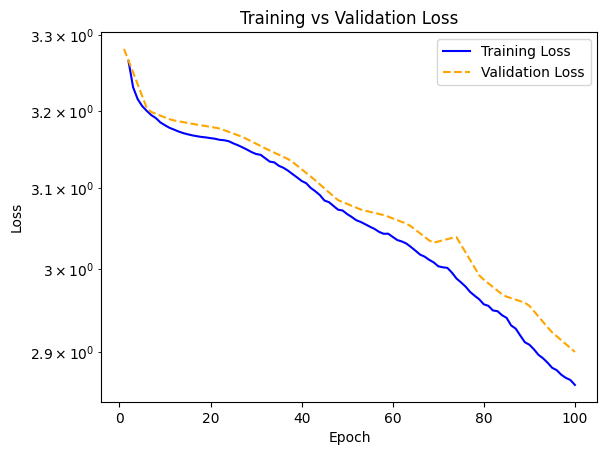

Train accuracy no validation = 12.78%
Test accuracy no validation = 7.67%
Train accuracy with validation = 12.28%
Test accuracy with validation = 7.31%







100%|██████████| 100/100 [02:03<00:00,  1.24s/it]


2 HIDDEN LAYER WITH (128, 128) units and a 0.01 learning rate


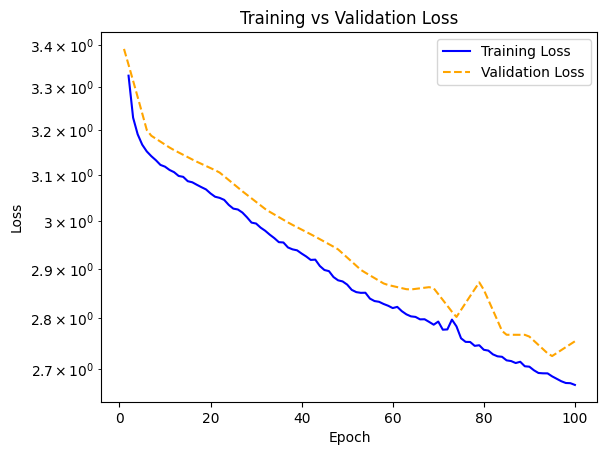

Train accuracy no validation = 17.31%
Test accuracy no validation = 12.48%
Train accuracy with validation = 16.67%
Test accuracy with validation = 11.45%







100%|██████████| 100/100 [03:00<00:00,  1.80s/it]


2 HIDDEN LAYER WITH (128, 256) units and a 0.01 learning rate


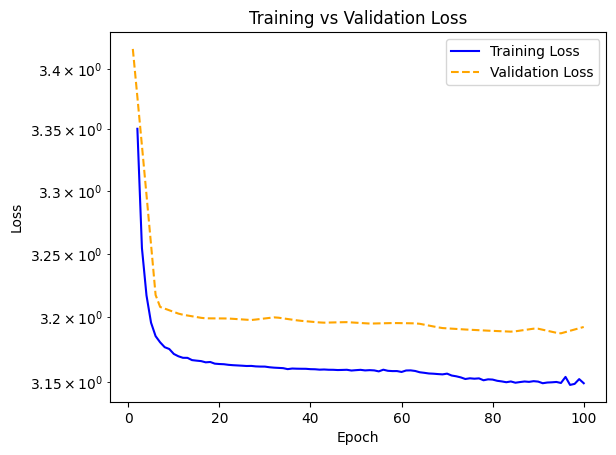

Train accuracy no validation = 5.48%
Test accuracy no validation = 2.30%
Train accuracy with validation = 5.48%
Test accuracy with validation = 2.31%







100%|██████████| 100/100 [02:25<00:00,  1.46s/it]


2 HIDDEN LAYER WITH (128, 32) units and a 0.001 learning rate


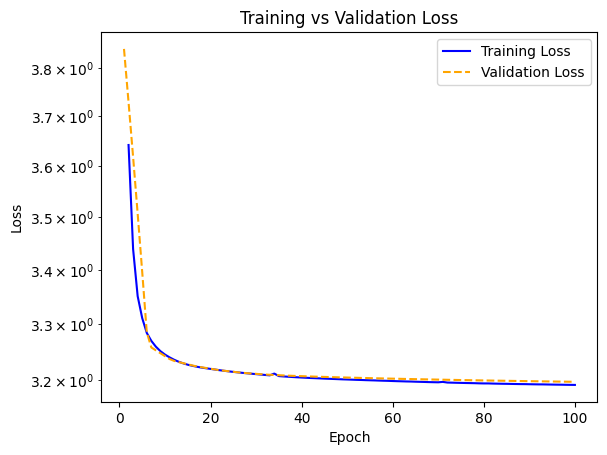

Train accuracy no validation = 4.75%
Test accuracy no validation = 2.02%
Train accuracy with validation = 4.75%
Test accuracy with validation = 2.02%







100%|██████████| 100/100 [02:24<00:00,  1.44s/it]


2 HIDDEN LAYER WITH (128, 64) units and a 0.001 learning rate


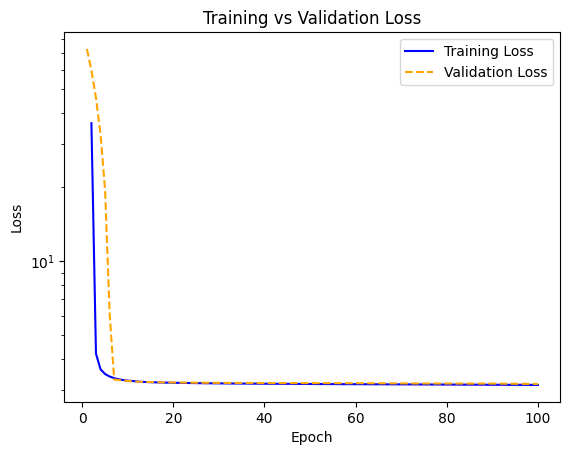

Train accuracy no validation = 6.19%
Test accuracy no validation = 2.86%
Train accuracy with validation = 6.13%
Test accuracy with validation = 2.84%







100%|██████████| 100/100 [02:45<00:00,  1.66s/it]


2 HIDDEN LAYER WITH (128, 128) units and a 0.001 learning rate


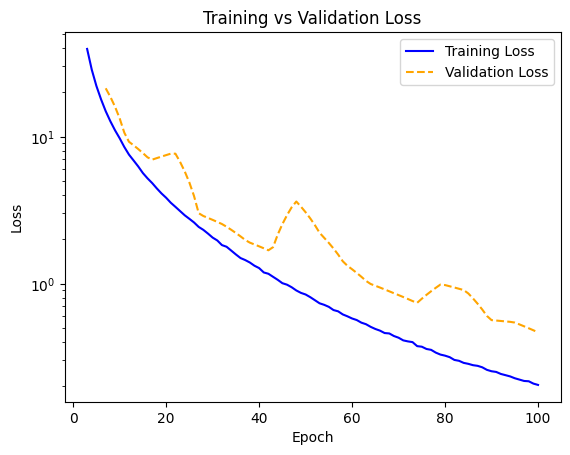

Train accuracy no validation = 93.87%
Test accuracy no validation = 50.07%
Train accuracy with validation = 94.18%
Test accuracy with validation = 50.50%







100%|██████████| 100/100 [02:57<00:00,  1.78s/it]


2 HIDDEN LAYER WITH (128, 256) units and a 0.001 learning rate


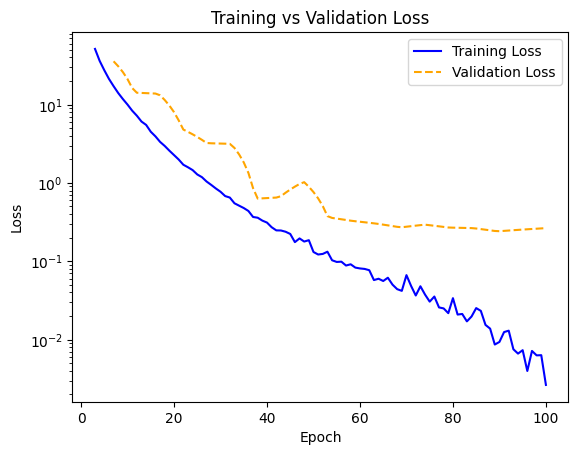

Train accuracy no validation = 99.66%
Test accuracy no validation = 55.91%
Train accuracy with validation = 99.48%
Test accuracy with validation = 55.62%







100%|██████████| 100/100 [05:34<00:00,  3.34s/it]


2 HIDDEN LAYER WITH (256, 32) units and a 1.0 learning rate


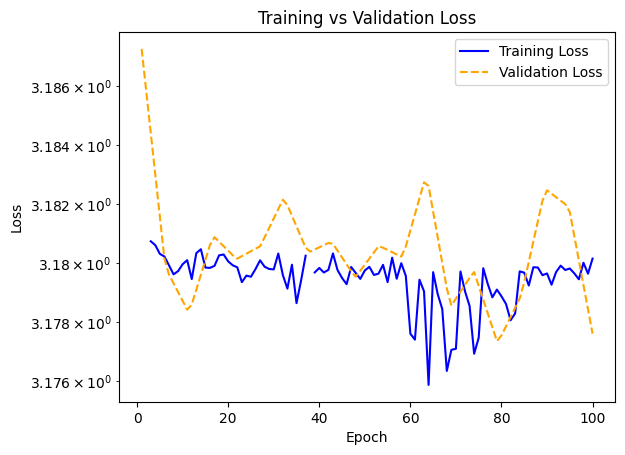

Train accuracy no validation = 4.72%
Test accuracy no validation = 2.02%
Train accuracy with validation = 4.73%
Test accuracy with validation = 2.02%







100%|██████████| 100/100 [05:48<00:00,  3.49s/it]

2 HIDDEN LAYER WITH (256, 64) units and a 1.0 learning rate


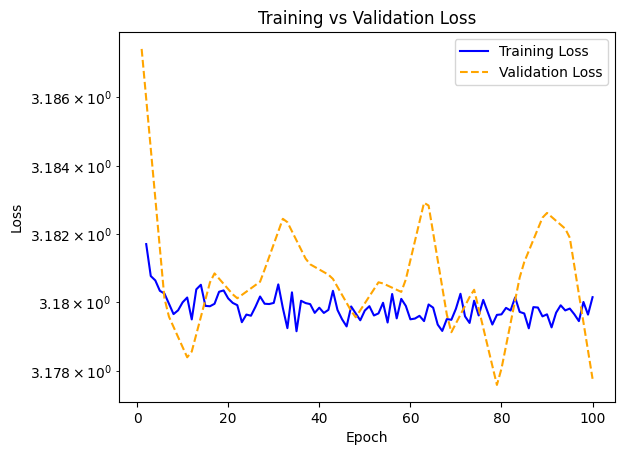

Train accuracy no validation = 4.71%
Test accuracy no validation = 2.01%
Train accuracy with validation = 4.71%
Test accuracy with validation = 2.01%







100%|██████████| 100/100 [06:10<00:00,  3.70s/it]


2 HIDDEN LAYER WITH (256, 128) units and a 1.0 learning rate


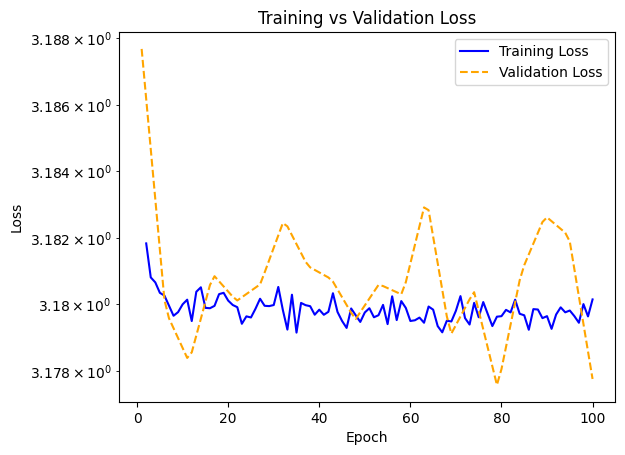

Train accuracy no validation = 4.71%
Test accuracy no validation = 2.01%
Train accuracy with validation = 4.71%
Test accuracy with validation = 2.01%







100%|██████████| 100/100 [06:41<00:00,  4.01s/it]


2 HIDDEN LAYER WITH (256, 256) units and a 1.0 learning rate


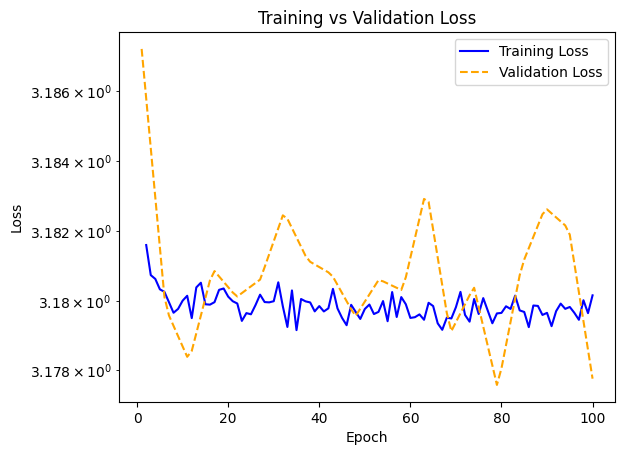

Train accuracy no validation = 4.71%
Test accuracy no validation = 2.01%
Train accuracy with validation = 4.71%
Test accuracy with validation = 2.01%







100%|██████████| 100/100 [06:00<00:00,  3.60s/it]

2 HIDDEN LAYER WITH (256, 32) units and a 0.1 learning rate


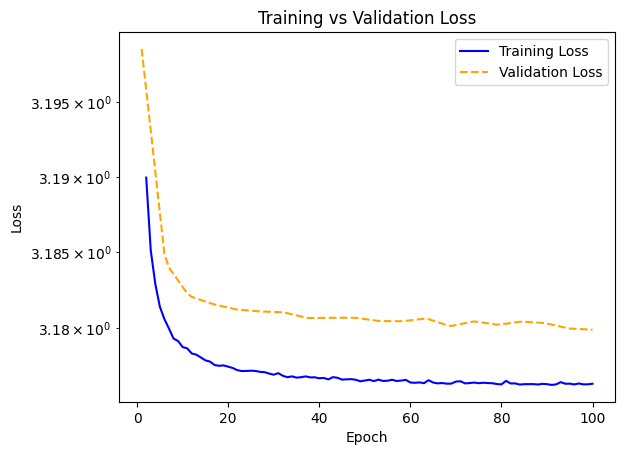

Train accuracy no validation = 4.71%
Test accuracy no validation = 2.01%
Train accuracy with validation = 4.71%
Test accuracy with validation = 2.01%







100%|██████████| 100/100 [06:00<00:00,  3.61s/it]


2 HIDDEN LAYER WITH (256, 64) units and a 0.1 learning rate


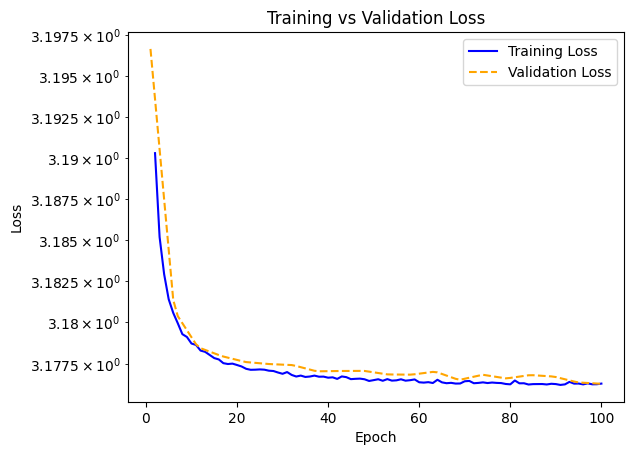

Train accuracy no validation = 4.71%
Test accuracy no validation = 2.01%
Train accuracy with validation = 4.71%
Test accuracy with validation = 2.01%







100%|██████████| 100/100 [06:17<00:00,  3.78s/it]


2 HIDDEN LAYER WITH (256, 128) units and a 0.1 learning rate


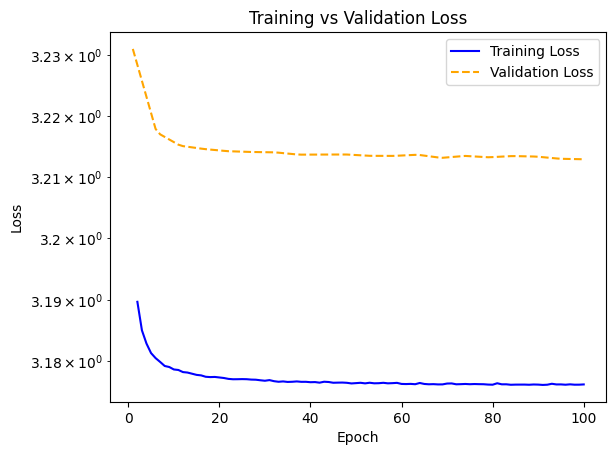

Train accuracy no validation = 4.71%
Test accuracy no validation = 2.01%
Train accuracy with validation = 4.71%
Test accuracy with validation = 2.01%







100%|██████████| 100/100 [07:20<00:00,  4.40s/it]


2 HIDDEN LAYER WITH (256, 256) units and a 0.1 learning rate


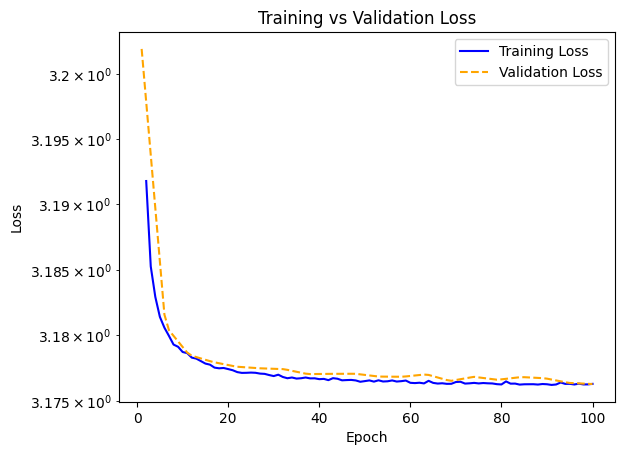

Train accuracy no validation = 4.71%
Test accuracy no validation = 2.01%
Train accuracy with validation = 4.71%
Test accuracy with validation = 2.01%







100%|██████████| 100/100 [06:40<00:00,  4.01s/it]


2 HIDDEN LAYER WITH (256, 32) units and a 0.01 learning rate


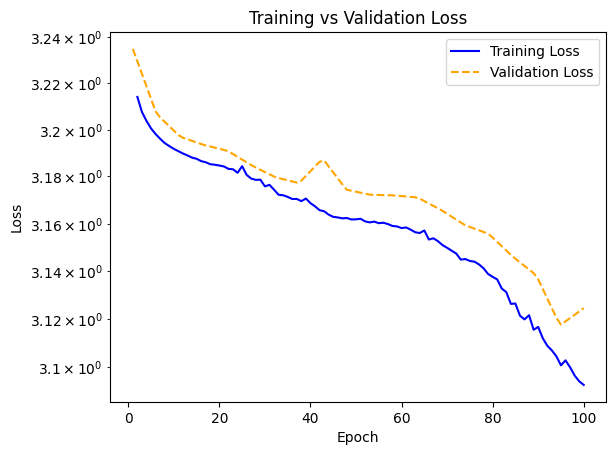

Train accuracy no validation = 7.17%
Test accuracy no validation = 3.15%
Train accuracy with validation = 6.87%
Test accuracy with validation = 3.03%







100%|██████████| 100/100 [07:52<00:00,  4.73s/it]


2 HIDDEN LAYER WITH (256, 64) units and a 0.01 learning rate


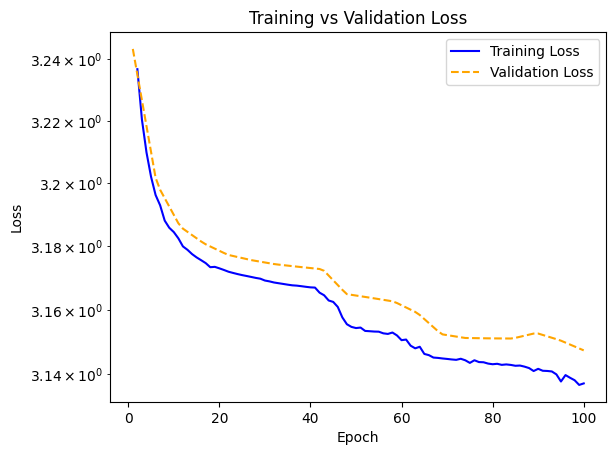

Train accuracy no validation = 6.05%
Test accuracy no validation = 2.30%
Train accuracy with validation = 5.97%
Test accuracy with validation = 2.23%







100%|██████████| 100/100 [07:39<00:00,  4.60s/it]


2 HIDDEN LAYER WITH (256, 128) units and a 0.01 learning rate


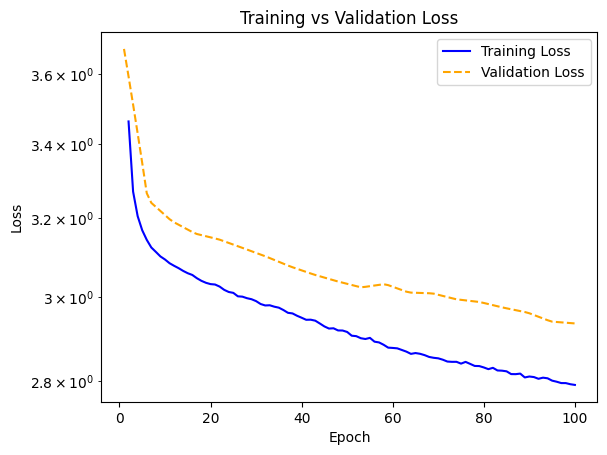

Train accuracy no validation = 15.59%
Test accuracy no validation = 9.05%
Train accuracy with validation = 15.37%
Test accuracy with validation = 8.87%







100%|██████████| 100/100 [08:30<00:00,  5.10s/it]


2 HIDDEN LAYER WITH (256, 256) units and a 0.01 learning rate


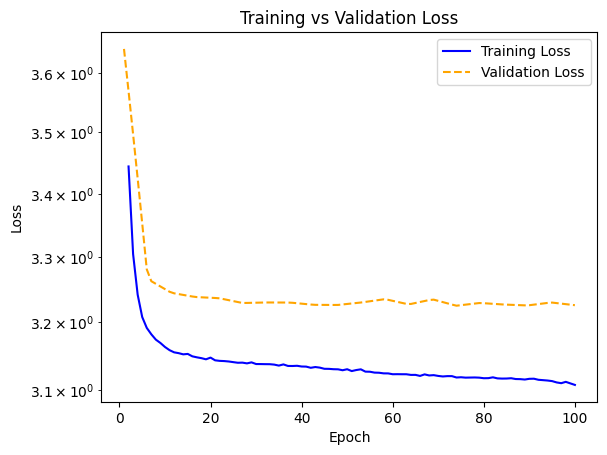

Train accuracy no validation = 6.96%
Test accuracy no validation = 2.75%
Train accuracy with validation = 6.47%
Test accuracy with validation = 2.66%







100%|██████████| 100/100 [06:14<00:00,  3.74s/it]


2 HIDDEN LAYER WITH (256, 32) units and a 0.001 learning rate


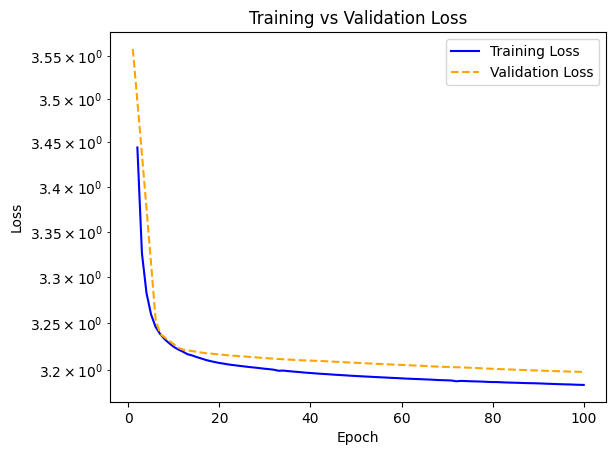

Train accuracy no validation = 4.96%
Test accuracy no validation = 2.04%
Train accuracy with validation = 4.96%
Test accuracy with validation = 2.04%







100%|██████████| 100/100 [07:09<00:00,  4.30s/it]


2 HIDDEN LAYER WITH (256, 64) units and a 0.001 learning rate


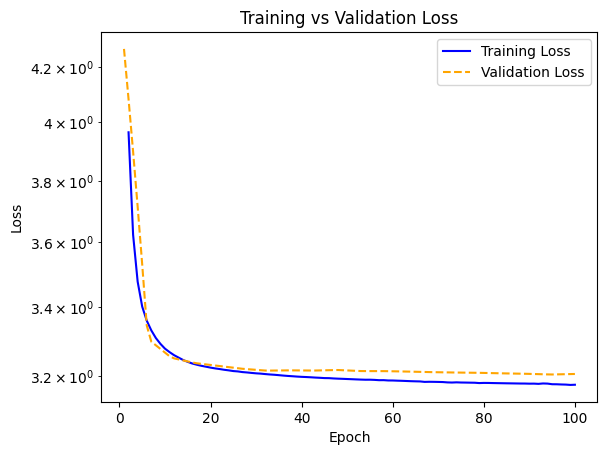

Train accuracy no validation = 5.32%
Test accuracy no validation = 2.11%
Train accuracy with validation = 5.27%
Test accuracy with validation = 2.11%







100%|██████████| 100/100 [07:04<00:00,  4.25s/it]


2 HIDDEN LAYER WITH (256, 128) units and a 0.001 learning rate


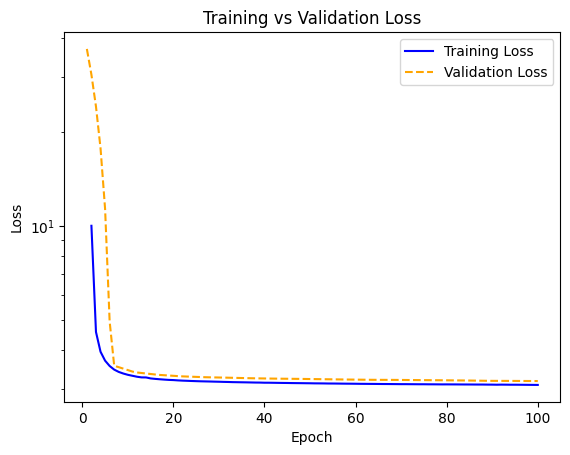

Train accuracy no validation = 8.08%
Test accuracy no validation = 3.28%
Train accuracy with validation = 8.02%
Test accuracy with validation = 3.23%







100%|██████████| 100/100 [07:56<00:00,  4.77s/it]


2 HIDDEN LAYER WITH (256, 256) units and a 0.001 learning rate


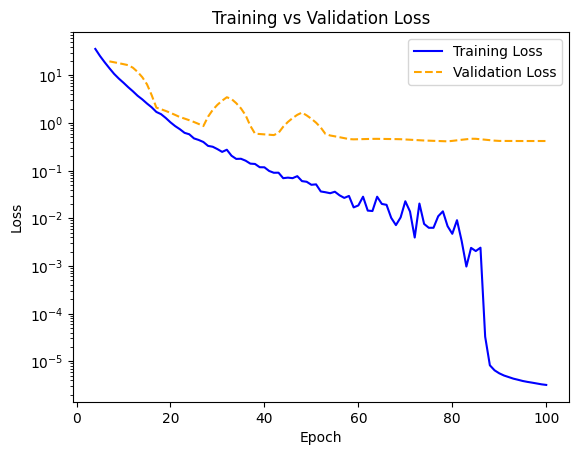

Train accuracy no validation = 99.72%
Test accuracy no validation = 52.96%
Train accuracy with validation = 99.64%
Test accuracy with validation = 52.84%







In [11]:
### ONLY CONSIDERING THE HIDDEN UNIT ONES FROM OUR 1-L MLP THAT HAD TEST ACCURACY >59%
HIDDEN_UNITS_1st = [64, 128, 256]
learning_rates = [1e0, 1e-1, 1e-2, 1e-3]       #256 --> 0.1, 0.01, 64 --> 0.01
HIDDEN_UNITS = [32, 64, 128, 256]
for i in HIDDEN_UNITS_1st:
        for j in learning_rates:
                for m in HIDDEN_UNITS:
                        mlp = MLP(hidden_layers=[i, m], activation_function='relu')
                        best_val_params, train_losses, val_losses = mlp.fit(X_train, y_train_ohe, learning_rate=j, epochs=100)
                        best_no_val_params = (copy.deepcopy(mlp.weights), copy.deepcopy(mlp.biases))
                        print(f"2 HIDDEN LAYER WITH {i, m} units and a {j} learning rate")
                        plot_losses(train_losses, val_losses)
                        no_hidden_layer_stats = get_accuracy_stats(mlp, best_no_val_params, best_val_params, X_test, y_test, X_train, y_train)
                        print("\n\n\n\n")

To be able to compare no and 1 hidden layer w. best parameters, will run ideal hyperparameters (128, 256, lr= 0.001) with 400 epochs

100%|██████████| 400/400 [11:22<00:00,  1.71s/it]


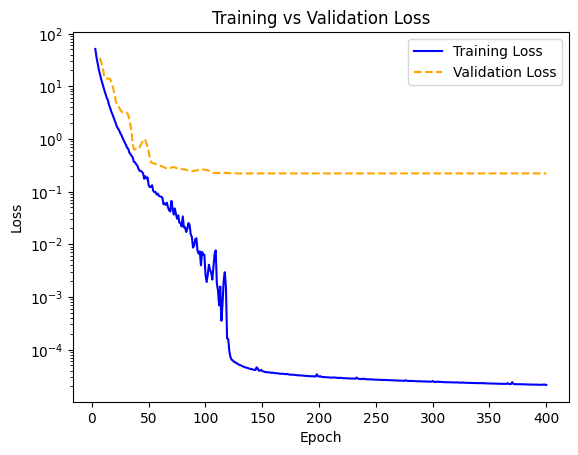

Train accuracy no validation = 99.69%
Test accuracy no validation = 55.90%
Train accuracy with validation = 99.69%
Test accuracy with validation = 55.90%


In [12]:
mlp = MLP(hidden_layers=[128, 256], activation_function='relu')
best_val_params, train_losses, val_losses = mlp.fit(X_train, y_train_ohe, learning_rate=0.001, epochs=400)
best_no_val_params = (copy.deepcopy(mlp.weights), copy.deepcopy(mlp.biases))
plot_losses(train_losses, val_losses)
no_hidden_layer_stats = get_accuracy_stats(mlp, best_no_val_params, best_val_params, X_test, y_test, X_train, y_train)

<h3> 3.2 Since 300 extra epochs didnt make much change, the rest will be implemnted using epochs = 100 on ideal hyperparameters </h3>

100%|██████████| 100/100 [02:52<00:00,  1.72s/it]


2 HIDDEN LAYER WITH [128, 256] units and a 0.001 learning rate for activation funtion leakyRelu


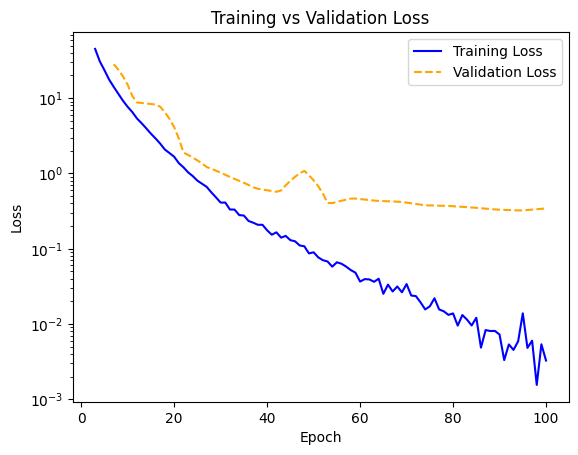

Train accuracy no validation = 99.57%
Test accuracy no validation = 52.77%
Train accuracy with validation = 99.59%
Test accuracy with validation = 52.77%







100%|██████████| 100/100 [03:37<00:00,  2.18s/it]


2 HIDDEN LAYER WITH [128, 256] units and a 0.001 learning rate for activation funtion relu


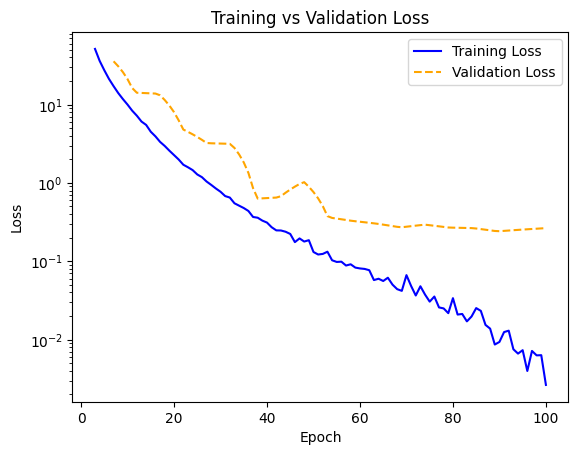

Train accuracy no validation = 99.66%
Test accuracy no validation = 55.91%
Train accuracy with validation = 99.48%
Test accuracy with validation = 55.62%







100%|██████████| 100/100 [04:02<00:00,  2.43s/it]


2 HIDDEN LAYER WITH [128, 256] units and a 0.001 learning rate for activation funtion sigmoid


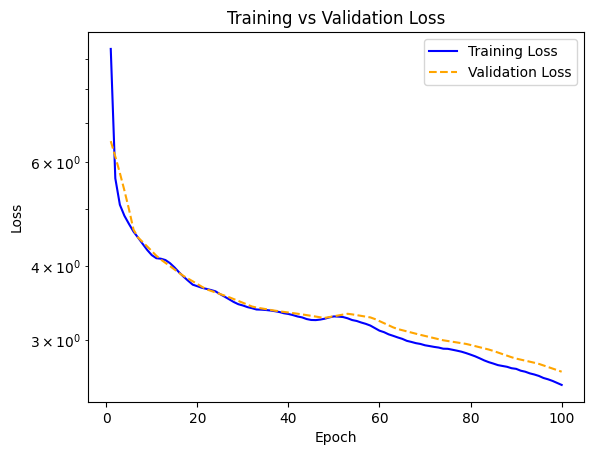

Train accuracy no validation = 31.57%
Test accuracy no validation = 28.22%
Train accuracy with validation = 30.23%
Test accuracy with validation = 27.38%







100%|██████████| 100/100 [07:35<00:00,  4.55s/it]


2 HIDDEN LAYER WITH [128, 256] units and a 0.001 learning rate for activation funtion tanh


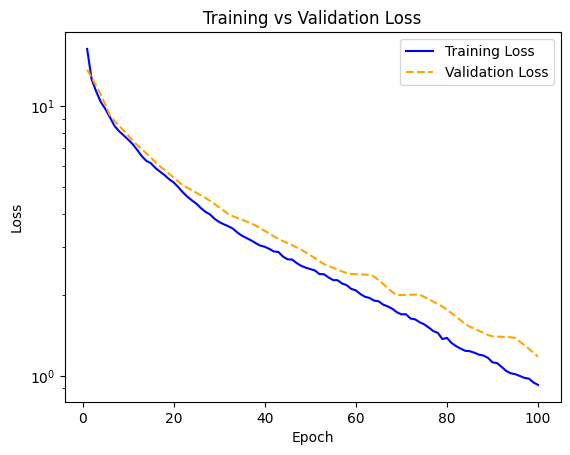

Train accuracy no validation = 78.63%
Test accuracy no validation = 49.14%
Train accuracy with validation = 76.70%
Test accuracy with validation = 49.09%







In [19]:
HIDDEN_UNITS = [128,256]
rate = 0.001
activation_functions = ['leakyRelu', 'relu', 'sigmoid', 'tanh']
for act in activation_functions:
        mlp = MLP(hidden_layers=HIDDEN_UNITS, activation_function=act)
        best_val_params, train_losses, val_losses = mlp.fit(X_train, y_train_ohe, learning_rate=rate, epochs=100)
        best_no_val_params = (copy.deepcopy(mlp.weights), copy.deepcopy(mlp.biases))
        print(f"2 HIDDEN LAYER WITH {HIDDEN_UNITS} units and a {rate} learning rate for activation funtion {act}")
        plot_losses(train_losses, val_losses)
        no_hidden_layer_stats = get_accuracy_stats(mlp, best_no_val_params, best_val_params, X_test, y_test, X_train, y_train)
        print("\n\n\n\n")

<h3> 3.3 </h3>

100%|██████████| 400/400 [11:39<00:00,  1.75s/it]


2 HIDDEN LAYER WITH [128, 256] units and a 0.001 learning rate with L2 reg of 0.001


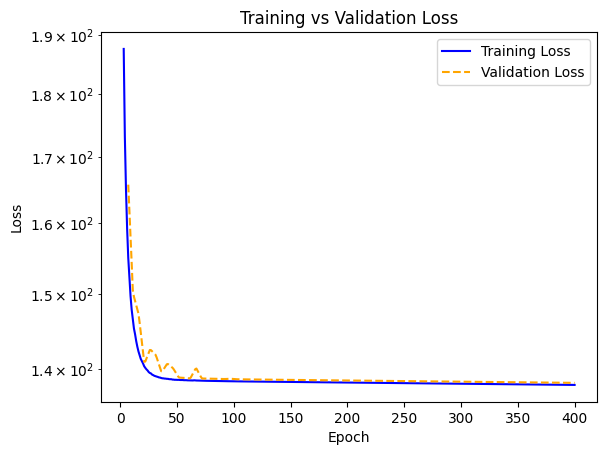

Train accuracy no validation = 99.68%
Test accuracy no validation = 53.86%
Train accuracy with validation = 99.68%
Test accuracy with validation = 53.86%







In [24]:
HIDDEN_UNITS = [128,256]
rate = 0.001
regularization = [0, 0.001, 0.01, 0.1]
for lam in regularization:
        mlp = MLP(hidden_layers=HIDDEN_UNITS, activation_function='relu', l2_lambda=lam)
        best_val_params, train_losses, val_losses = mlp.fit(X_train, y_train_ohe, learning_rate=rate, epochs=400)
        best_no_val_params = (copy.deepcopy(mlp.weights), copy.deepcopy(mlp.biases))
        print(f"2 HIDDEN LAYER WITH {HIDDEN_UNITS} units and a {rate} learning rate with L2 reg of {lam}")
        plot_losses(train_losses, val_losses)
        no_hidden_layer_stats = get_accuracy_stats(mlp, best_no_val_params, best_val_params, X_test, y_test, X_train, y_train)
        print("\n\n\n\n")

<h4> 3.4 </h4>

Using existing libraries such as Keras/TensorFlow or PyTorch, create a Convolutional
Neural Network (ConvNet) with 3 convolutional and 2 fully connected layers. You are free
in your choice of the hyperparameters of the convolutional layers. Experiment again with
using {32,64,128,256} hidden units in the fully connected layers and choose the best one.
Also, set the activations in all of the layers to be ReLU. Train this ConvNet on the Sign
Language MNIST dataset. Does using a ConvNet increase/decrease the accuracy compared to using MLPs? Provide comments on your results.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self, number_of_hidden_units):
        super(ConvNet, self).__init__()

        #convolution -> input image is 28x28x1 (Width x Depth x Channels)
        #output dimensions = (xh + 2ph - fh + 1) x (xw + 2pw - fw +1)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1) #output -> (28 + 2*1 - 3 + 1) = 28x28x32
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1) #output -> 28x28x64
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1) #output -> 28x28x128

        #At this point if we flatten the image to vector representation for the linear layer, our input dimension would be 28*28*128=100,352 which is insanely large
        #We can apply max pooling, but we haven't really seen it in class I don't think unless I'm just behind on lectures
        #Its really quite simple, and because of the autograd provided by pytorch we don't have to think too hard about the math

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) #Applying this effectively halves both the width and the height -> a 2x2 square in the orginal image is pooled to only the maximum value so 2x2 becomes 1. Stride of two allows this to never overlap

        #if we anticipate applying max pooling after conv1 then that yields 14x14x32
        #if we apply it after conv2 then that yields 7x7x64
        #So our input to the linear fully connected layers is 7x7x128 (after convolution 3) -> 128 separate 7x7 images (Feature maps)
        self.fc1 = nn.Linear(128*7*7, number_of_hidden_units)
        self.fc2 = nn.Linear(number_of_hidden_units, 25) #25 output units as previous (25 classes->really only 24 because there's a 0 examples of J and z is just chopped off the end)
    
    def forward(self, x, apply_softmax = False):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = F.relu(x)
        x= self.pool(x)

        x = self.conv3(x)
        x = F.relu(x)

        #Now we need to flatten the image to a vector representation
        x = x.view(-1, 7*7*128) #-1 allows pytorch to infer the size (batch dimension), 7x7x128 is as discussed above

        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        if apply_softmax: #We only apply softmax if we need to, nn.CrossEntropyLoss does this internally for efficiency. So we will call forward(x, True) when we want probabilities instead of logits
            x = F.softmax(x, dim=1)

        return x

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, random_split

full_train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

val_size = int(len(X_train_tensor)*0.2) #80:20 split
train_size = len(X_train_tensor)-val_size

train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

number_of_hidden_units_TORCH = 64 #To change


In [ ]:
import torch.optim as optim

conv_net = ConvNet(number_of_hidden_units=number_of_hidden_units_TORCH).float()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
conv_net.to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(conv_net.parameters(), lr = 0.001)

train_losses = []
val_losses = []

num_epochs = 300
for epoch in range(num_epochs):

    conv_net.train()
    train_loss = 0.0

    for images, labels in train_loader:

        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        
        outputs = conv_net(images)
        loss = loss_function(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss+=loss.item()

    conv_net.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = conv_net(images)
            loss = loss_function(outputs, labels)
            val_loss+=loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss/len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

# We can save the model parameters as a .pth file
model_path = 'conv_net_params.pth'
torch.save(conv_net.state_dict(), model_path)

plot_losses(train_losses, val_losses)

In [ ]:
def get_accuracy_stats_TORCH(model : ConvNet, params_path, X_test:torch.tensor, y_test:torch.tensor, X_train:torch.tensor, y_train:torch.tensor):
    model.load_state_dict(torch.load(params_path))
    model.eval() #faster

    device = torch.device("cpu")
    model.to(device)
    X_test=X_test.to(device)
    y_test=y_test.to(device)
    X_train=X_train.to(device)
    y_train=y_train.to(device)

    with torch.no_grad():
        probabilities_test = model.forward(X_test, apply_softmax=True)
        test_accuracy = evaluate_accuracy(y_test.numpy(), probabilities_test.numpy())*100
        probabilities_train = model.forward(X_train, apply_softmax=True)
        train_accuracy = evaluate_accuracy(y_train.numpy(), probabilities_train.numpy())*100
    
    print(f"Train accuracy = {train_accuracy:.2f}%")
    print(f"Test accuracy = {test_accuracy:.2f}%")
    return train_accuracy, test_accuracy

In [ ]:
get_accuracy_stats_TORCH(conv_net, model_path, X_test_tensor, y_test_tensor, X_train_tensor, y_train_tensor)

<h3> 3.5 </h3>

We will be implementing a 1 hidden layer with L2 reg to see if we can improve MLP implementation as much as possible

In [ ]:
# More accurate for 1 layer, relu, hidden layer and learning rate, l2 reg, 

mlp = MLP(hidden_layers=[256], activation_function='relu', l2_lambda=1e-3)
best_val_params, train_losses, val_losses = mlp.fit(X_train, y_train_ohe, learning_rate=0.1, epochs=400)
best_no_val_params = (copy.deepcopy(mlp.weights), copy.deepcopy(mlp.biases))
plot_losses(train_losses, val_losses)
no_hidden_layer_stats = get_accuracy_stats(mlp, best_no_val_params, best_val_params, X_test, y_test, X_train, y_train)